In [1]:
import warnings
warnings.filterwarnings("ignore")

import os, re
import copy
from tqdm import tqdm
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, TensorDataset
from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torchtext.vocab import build_vocab_from_iterator

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from razdel import tokenize
import pymorphy2
from nltk.corpus import stopwords

pd.set_option('display.max_colwidth', None)

In [2]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device.upper()}" device.')

Currently using "CUDA" device.


In [3]:
stopword_ru = stopwords.words('russian')
morph = pymorphy2.MorphAnalyzer()

token_transform = get_tokenizer("spacy", language="ru_core_news_sm")

In [4]:
data = pd.read_excel("feedbacks_summer.xls", parse_dates=["Date"]).sort_values("Date")
data.head()

# we will solve classification task as ratings are provided as descrete values

,Rating,Content,Date
20658,5,Сбербанк бомбовая компания на сегодняшний день. Лидер банков.!! Держитесь в том же духе.,2017-06-01
20634,5,"Недавно пользуюсь, но то, что я использовал, работает отлично.",2017-06-01
20633,5,все отлично!,2017-06-01
20632,2,"Уважаемые разработчики, после последнего обновления я не могу зайти в приложение, зеленая полоска зависает на инициализации антивируса. У меня хонор 8 или вы теперь все сделали только для самсунгов? Когда вы обратите внимание на мои отзывы, я уже пишу вам ТРЕТИЙ раз!",2017-06-01
20631,2,"Что вообще случилось после последнего обновления? Инициализация интивируса очень очень оооочень долгая и с момента обновления ни разу я не дождалась окончания этой инициализации и соответственно ни разу не зашла в приложение! Было плохо,стало еще хуже!",2017-06-01


In [5]:
data["Rating"].value_counts()

5    14586
1     2276
4     2138
3      911
2      748
Name: Rating, dtype: int64

In [5]:
data["month"] = data["Date"].dt.month
data["day"] = data["Date"].dt.day

data.drop("Date", axis=1, inplace=True)

In [6]:
def clean_text(text, tokenized=False):
    
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", ' ', str(text))
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())

    text = re.sub("\W+", ' ', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    
    if not isinstance(text, str):
        text = str(text)
    
    if tokenized:
        tokens = list(tokenize(text))
        words = [_.text for _ in tokens]
        words = [w for w in words if w not in stopword_ru]
        return " ".join(words)
    
    return text

cache = {}

def lemmatization(text):

    if not isinstance(text, str):
        text = str(text)

        tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-':
            w = w[1:]
        if len(w)>1:
            if w in cache:
                words_lem.append(cache[w])
            else:
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru]
    
    return words_lem_without_stopwords

In [7]:
# clean and split

data["Content"] = data["Content"].apply(lambda x: clean_text(x, tokenized=True))

<AxesSubplot:>

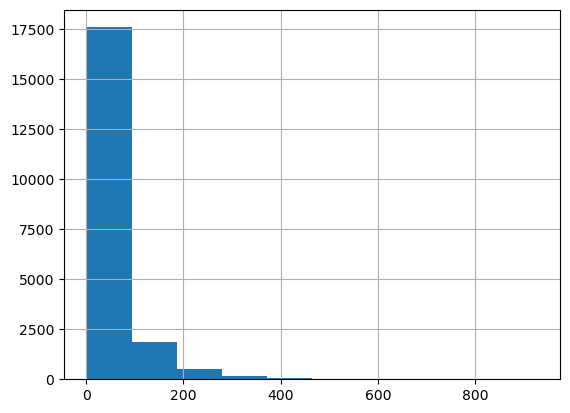

In [155]:
data["Content"].str.len().hist()

In [8]:
data = data[~(data["Content"].str.len() == 0)]
data["Rating"] = data["Rating"] - 1

In [9]:
def yield_tokens(data_iter):

    for data_sample in data_iter:
        yield token_transform(data_sample[0])  # [1] - label

In [10]:
PAD_IDX, UNK_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ["<pad>", "<unk>", "<bos>", "<eos>"]

In [11]:
# split by date? not so huge period -> just shuffle

train, valid = train_test_split(data, test_size=0.1, shuffle=True, stratify=data["Rating"], random_state=42)
valid, test = train_test_split(valid, test_size=500, shuffle=True, random_state=42)
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [12]:
class_counts = train["Rating"].value_counts().to_list()
num_samples = sum(class_counts)
labels = train["Rating"].values - 1

class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

In [13]:
# Dataset

class TextDataset(Dataset):
    def __init__(self, data, max_len=64):
        self.data = data
        self.max_len = max_len

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, ix):
        row = self.data.iloc[ix].squeeze()
        text = row["Content"]
        label = row["Rating"]
        
        return text, label

    def collate_fn(self, batch):
        texts, labels = list(zip(*batch))
        
        text_batch = torch.zeros((len(texts), self.max_len)).fill_(PAD_IDX).long()
        
        # constant max_length
        for i in range(len(texts)):
            sample = text_transform(texts[i])[:self.max_len]
            text_batch[i, :len(sample)] = sample

        # text_batch = pad_sequence(text_batch, padding_value=PAD_IDX, batch_first=True).to(device) # pads only to current max
        
        labels = torch.cat([torch.tensor(label).unsqueeze(0) for label in labels]).to(device)
        return text_batch.to(device), labels

In [14]:
data_iter = TextDataset(data)

vocabulary = build_vocab_from_iterator(yield_tokens(data_iter),  # define Dataset
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)
vocabulary.set_default_index(UNK_IDX)

In [15]:
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

def tensor_transform(token_ids, drop_specials=True):
    if drop_specials:
        return torch.tensor(token_ids)
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

text_transform = sequential_transforms(token_transform,
                                       vocabulary,
                                       tensor_transform)

In [16]:
train_ds = TextDataset(train)
valid_ds = TextDataset(valid)
test_ds = TextDataset(test)

train_dataloader = DataLoader(train_ds, batch_size=128, shuffle=True, collate_fn=train_ds.collate_fn)
# train_dataloader = DataLoader(train_ds, batch_size=128, shuffle=False, sampler=sampler, collate_fn=train_ds.collate_fn)
valid_dataloader = DataLoader(valid_ds, batch_size=128, collate_fn=valid_ds.collate_fn)
test_dataloader = DataLoader(test_ds, batch_size=64, collate_fn=test_ds.collate_fn)

In [16]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, path='model.pth'):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model=None):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            if model is not None:
                checkpoint = {
                    'model': model,
                }
                torch.save(checkpoint, self.path)
                print(f'Model saved to: {self.path}')
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True
                
def calc_accuracy(y_pred, y_true):
    return (y_true == torch.max(y_pred, 1)[1]).float().mean()


class FocalLoss(nn.Module):
    """ 
    https://github.com/AdeelH/pytorch-multi-class-focal-loss/blob/master/focal_loss.py
    
    Shape:
        - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
        - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
    """
    def __init__(self, *args, 
                 alpha: torch.Tensor = None, 
                 gamma: float = 2.0, 
                 reduction: str = 'mean',
                 ignore_index: int = -100,
                 **kwargs
                 ):
        """
        Args:
            alpha (Tensor, optional): Weights for each class. Defaults to None.
            gamma (float, optional): A constant, as described in the paper.
                Defaults to 2.0
            reduction (str, optional): 'mean', 'sum' or 'none'.
                Defaults to 'mean'.
            ignore_index (int, optional): class label to ignore.
                Defaults to -100.
        """
        if reduction not in ('mean', 'sum', 'none'):
            raise ValueError(
                'Reduction must be one of: "mean", "sum", "none".')

        super(FocalLoss, self).__init__(*args, **kwargs)
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.reduction = reduction

        self.nll_loss = nn.NLLLoss(
            weight=alpha, reduction='none', ignore_index=ignore_index)

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        if x.ndim > 2:
            c = x.shape[1]  # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            y = y.view(-1)  # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
        
        y = y.long()
        unignored_mask = y != self.ignore_index
        y = y[unignored_mask]
        if len(y) == 0:
            return torch.tensor(0.)
        x = x[unignored_mask]

        # compute weighted cross entropy term: -alpha * log(pt) (alpha is already part of self.nll_loss)
        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        # get true class column from each row
        all_rows = torch.arange(len(x))
        log_pt = log_p[all_rows, y]

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt)**self.gamma

        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        loss = focal_term * ce

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()

        return loss

In [17]:
def train_one_batch(data, model, criterion, optimizer):
    model.train()
    texts, labels = data
    optimizer.zero_grad()
    output = model(texts)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    accuracy = calc_accuracy(output, labels)
    return loss.item(), accuracy.item()


@torch.no_grad()
def validate_one_batch(data, model, criterion):
    model.eval()
    texts, labels = data
    
    out = model(texts)
    loss = criterion(out, labels)
    
    accuracy = calc_accuracy(out, labels)
    
    return loss.item(), accuracy.item()

In [17]:
def run(model, epochs=40, print_freq=50):

    for epoch in range(1, epochs+1):

        train_loss, train_accs = [], []
        for step, batch in enumerate(train_dataloader, 1):
            time_1 = time.time()

            loss, accuracy = train_one_batch(batch, model, criterion, optimizer)

            train_loss.append(loss)
            train_accs.append(accuracy)

            if step % print_freq == 0:
                print('epoch:', epoch, 
                      '\tstep:', step, '/', len(train_dataloader),
                      '\ttrain loss:', '{:.4f}'.format(loss),
                      '\ttrain accuracy:','{:.4f}'.format(accuracy),
                      '\ttime:', '{:.4f}'.format((time.time()-time_1)*print_freq), 's')

        valid_loss, valid_accs = [], []
        for step, batch in enumerate(tqdm(valid_dataloader)):
            loss, accuracy = validate_one_batch(batch, model, criterion)

            valid_loss.append(loss)
            valid_accs.append(accuracy)

        print('epoch:', epoch, '/', epochs,
              '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)),
              '\tvalid loss:', '{:.4f}'.format(np.mean(valid_loss)),
              '\ttrain accuracy', '{:.4f}'.format(np.mean(train_accs)),
              '\tvalid accuracy', '{:.4f}'.format(np.mean(valid_accs)))

        stopper(np.mean(valid_loss), model)
        if stopper.early_stop:
            checkpoint = torch.load("model.pth", map_location=device)
            model = checkpoint['model']
            break
        scheduler.step(np.mean(valid_loss))

    test_loss, test_accs = [], []
    for step, batch in enumerate(tqdm(test_dataloader)):
        loss, accuracy = validate_one_batch(batch, model, criterion)

        test_loss.append(loss)
        test_accs.append(accuracy)

    print('\ttest loss:', '{:.4f}'.format(np.mean(test_loss)),
          '\ttest accuracy', '{:.4f}'.format(np.mean(test_accs)),)

**Models**

* CNN
* LSTM 
* LSTM-CNN
* Transformer

**CNN**

In [50]:
class CNNModel(nn.Module):
    def __init__(self, hidden_dim, vocab_size, num_classes=5, dropout=0.1, **kwargs):
        super(CNNModel ,self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, hidden_dim)  #, padding_idx=PAD_IDX)  # default = 0
        self.conv1 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=1)
        
        self.cconv1 = nn.Conv1d(hidden_dim, hidden_dim//4, kernel_size=1, padding=0)
        self.cconv2 = nn.Conv1d(hidden_dim, hidden_dim//4, kernel_size=2, padding=1)
        self.cconv3 = nn.Conv1d(hidden_dim, hidden_dim//4, kernel_size=3, padding=1)
        self.cconv4 = nn.Conv1d(hidden_dim, hidden_dim//4, kernel_size=5, padding=2)
        self.cbatch = nn.BatchNorm1d(hidden_dim)
        
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim*2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(hidden_dim*2, hidden_dim*2, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(hidden_dim*2, hidden_dim*4, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(hidden_dim*4, hidden_dim*4, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        
        self.reducer = nn.Linear(hidden_dim*4, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        x = self.embedding(x)
        x = x.contiguous().permute(0,2,1)  # [B, SEQ_LEN, hidden] -> [B, hidden, SEQ_LEN] to slide over sequence for n-gramms
        
        # x = self.conv1(x)  # comment to simplify
        # x = F.relu(x)
        
        in_x1 = self.cconv1(x)
        in_x2 = self.cconv1(x)
        in_x3 = self.cconv1(x)
        in_x4 = self.cconv1(x)
        in_x = torch.cat([in_x1, in_x2, in_x3, in_x4], dim=1)
        # in_x = self.cbatch(x)
        in_x = F.relu(in_x)
        
        x = self.conv2(in_x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv5(x)
        x = F.relu(x)
        # x = self.pool(x)
        x = torch.max(x, dim=2)[0]  # obtain max n-gramm info
        # x = x.contiguous().view(x.size(0), -1)
        x = self.reducer(x)
        x = F.relu(x)
        
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

In [63]:
model = CNNModel(hidden_dim=64, vocab_size=len(vocabulary), dropout=0.3, num_classes=5).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, min_lr=1e-7, factor=0.1)
stopper = EarlyStopping(patience=4)

In [64]:
run(model)

epoch: 1 	step: 50 / 143 	train loss: 0.6754 	train accuracy: 0.7969 	time: 0.5044 s
epoch: 1 	step: 100 / 143 	train loss: 0.8444 	train accuracy: 0.7031 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.33it/s]


epoch: 1 / 40 	train loss: 0.8926 	valid loss: 0.7425 	train accuracy 0.7076 	valid accuracy 0.7298
epoch: 2 	step: 50 / 143 	train loss: 0.7142 	train accuracy: 0.7500 	time: 0.7812 s
epoch: 2 	step: 100 / 143 	train loss: 0.7884 	train accuracy: 0.7109 	time: 0.6000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.04it/s]


epoch: 2 / 40 	train loss: 0.7108 	valid loss: 0.7263 	train accuracy 0.7527 	valid accuracy 0.7437
Model saved to: model.pth
epoch: 3 	step: 50 / 143 	train loss: 0.6253 	train accuracy: 0.7656 	time: 0.7838 s
epoch: 3 	step: 100 / 143 	train loss: 0.5406 	train accuracy: 0.8047 	time: 0.7779 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.01it/s]


epoch: 3 / 40 	train loss: 0.6679 	valid loss: 0.6938 	train accuracy 0.7677 	valid accuracy 0.7475
Model saved to: model.pth
epoch: 4 	step: 50 / 143 	train loss: 0.6675 	train accuracy: 0.7578 	time: 0.7784 s
epoch: 4 	step: 100 / 143 	train loss: 0.5924 	train accuracy: 0.7734 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.12it/s]


epoch: 4 / 40 	train loss: 0.6377 	valid loss: 0.6891 	train accuracy 0.7777 	valid accuracy 0.7554
Model saved to: model.pth
epoch: 5 	step: 50 / 143 	train loss: 0.6113 	train accuracy: 0.7812 	time: 0.0875 s
epoch: 5 	step: 100 / 143 	train loss: 0.5761 	train accuracy: 0.7969 	time: 0.7846 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 53.92it/s]


epoch: 5 / 40 	train loss: 0.6098 	valid loss: 0.6841 	train accuracy 0.7843 	valid accuracy 0.7553
Model saved to: model.pth
epoch: 6 	step: 50 / 143 	train loss: 0.5564 	train accuracy: 0.8047 	time: 0.5995 s
epoch: 6 	step: 100 / 143 	train loss: 0.5142 	train accuracy: 0.8203 	time: 0.7844 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.82it/s]


epoch: 6 / 40 	train loss: 0.5731 	valid loss: 0.7411 	train accuracy 0.7942 	valid accuracy 0.7515
INFO: Early stopping counter 1 of 4
epoch: 7 	step: 50 / 143 	train loss: 0.5362 	train accuracy: 0.7969 	time: 0.6004 s
epoch: 7 	step: 100 / 143 	train loss: 0.5234 	train accuracy: 0.7891 	time: 0.7813 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.23it/s]


epoch: 7 / 40 	train loss: 0.5450 	valid loss: 0.7115 	train accuracy 0.8058 	valid accuracy 0.7535
INFO: Early stopping counter 2 of 4
epoch: 8 	step: 50 / 143 	train loss: 0.4389 	train accuracy: 0.8438 	time: 0.6001 s
epoch: 8 	step: 100 / 143 	train loss: 0.5128 	train accuracy: 0.8125 	time: 0.3882 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.88it/s]


epoch: 8 / 40 	train loss: 0.5186 	valid loss: 0.7698 	train accuracy 0.8141 	valid accuracy 0.7422
INFO: Early stopping counter 3 of 4
epoch: 9 	step: 50 / 143 	train loss: 0.5304 	train accuracy: 0.8125 	time: 0.5502 s
epoch: 9 	step: 100 / 143 	train loss: 0.4870 	train accuracy: 0.8047 	time: 0.7773 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.31it/s]


epoch: 9 / 40 	train loss: 0.4585 	valid loss: 0.8064 	train accuracy 0.8362 	valid accuracy 0.7418
INFO: Early stopping counter 4 of 4
INFO: Early stopping


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 119.68it/s]

	test loss: 0.6681 	test accuracy 0.7626


**Bidirectional LSTM**

In [34]:
class BiLSTM(nn.Module):
    def __init__(self, hidden_dim, vocab_size, num_classes=5, dropout=0.1, num_layers=2, **kwargs):
        super(BiLSTM, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(input_size=hidden_dim, 
                            hidden_size=hidden_dim, 
                            num_layers=num_layers, 
                            batch_first=True,
                            dropout=dropout,
                            bidirectional=True)
        self.dropout = nn.Dropout(p=dropout)
        self.fc_mid = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc_out = nn.Linear(hidden_dim*2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
                
        x, _ = self.lstm(x)
        
        avg_pool = torch.mean(x, dim=1)
        max_pool = torch.max(x, dim=1)[0]
        
        x = torch.cat((avg_pool, max_pool), dim=1)
        
        x = F.relu(self.fc_mid(self.dropout(x)))

        x = self.fc_out(x)
        return x

In [39]:
model = BiLSTM(hidden_dim=64, vocab_size=len(vocabulary), dropout=0.3, num_layers=1).to(device)

criterion = nn.CrossEntropyLoss()
# criterion = FocalLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.00005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, min_lr=1e-7, factor=0.5)
stopper = EarlyStopping(patience=4)

In [40]:
run(model)

epoch: 1 	step: 50 / 143 	train loss: 1.0736 	train accuracy: 0.7344 	time: 0.0000 s
epoch: 1 	step: 100 / 143 	train loss: 0.9460 	train accuracy: 0.7109 	time: 0.5500 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.93it/s]


epoch: 1 / 40 	train loss: 1.1043 	valid loss: 0.9209 	train accuracy 0.6804 	valid accuracy 0.6976
epoch: 2 	step: 50 / 143 	train loss: 0.8735 	train accuracy: 0.7031 	time: 0.0000 s
epoch: 2 	step: 100 / 143 	train loss: 0.8829 	train accuracy: 0.7031 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 62.07it/s]


epoch: 2 / 40 	train loss: 0.8674 	valid loss: 0.8355 	train accuracy 0.7102 	valid accuracy 0.7221
Model saved to: model.pth
epoch: 3 	step: 50 / 143 	train loss: 0.7605 	train accuracy: 0.7109 	time: 0.0000 s
epoch: 3 	step: 100 / 143 	train loss: 0.7622 	train accuracy: 0.7344 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.05it/s]


epoch: 3 / 40 	train loss: 0.8042 	valid loss: 0.7984 	train accuracy 0.7265 	valid accuracy 0.7319
Model saved to: model.pth
epoch: 4 	step: 50 / 143 	train loss: 0.7229 	train accuracy: 0.7734 	time: 0.7809 s
epoch: 4 	step: 100 / 143 	train loss: 0.7718 	train accuracy: 0.7109 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.05it/s]


epoch: 4 / 40 	train loss: 0.7768 	valid loss: 0.7753 	train accuracy 0.7311 	valid accuracy 0.7366
Model saved to: model.pth
epoch: 5 	step: 50 / 143 	train loss: 0.8357 	train accuracy: 0.7266 	time: 0.7808 s
epoch: 5 	step: 100 / 143 	train loss: 0.7520 	train accuracy: 0.7188 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 64.12it/s]


epoch: 5 / 40 	train loss: 0.7559 	valid loss: 0.7570 	train accuracy 0.7369 	valid accuracy 0.7411
Model saved to: model.pth
epoch: 6 	step: 50 / 143 	train loss: 0.8109 	train accuracy: 0.6953 	time: 0.0000 s
epoch: 6 	step: 100 / 143 	train loss: 0.6021 	train accuracy: 0.7891 	time: 0.6039 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.52it/s]


epoch: 6 / 40 	train loss: 0.7357 	valid loss: 0.7438 	train accuracy 0.7435 	valid accuracy 0.7418
Model saved to: model.pth
epoch: 7 	step: 50 / 143 	train loss: 0.6336 	train accuracy: 0.7969 	time: 0.5495 s
epoch: 7 	step: 100 / 143 	train loss: 0.7532 	train accuracy: 0.7422 	time: 0.5089 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.07it/s]


epoch: 7 / 40 	train loss: 0.7205 	valid loss: 0.7327 	train accuracy 0.7483 	valid accuracy 0.7424
Model saved to: model.pth
epoch: 8 	step: 50 / 143 	train loss: 0.7197 	train accuracy: 0.7344 	time: 0.7807 s
epoch: 8 	step: 100 / 143 	train loss: 0.7835 	train accuracy: 0.7266 	time: 0.2999 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 64.26it/s]


epoch: 8 / 40 	train loss: 0.7111 	valid loss: 0.7251 	train accuracy 0.7518 	valid accuracy 0.7437
Model saved to: model.pth
epoch: 9 	step: 50 / 143 	train loss: 0.8122 	train accuracy: 0.7266 	time: 0.5496 s
epoch: 9 	step: 100 / 143 	train loss: 0.6631 	train accuracy: 0.7812 	time: 0.5500 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 63.80it/s]


epoch: 9 / 40 	train loss: 0.7007 	valid loss: 0.7188 	train accuracy 0.7542 	valid accuracy 0.7457
Model saved to: model.pth
epoch: 10 	step: 50 / 143 	train loss: 0.6609 	train accuracy: 0.7656 	time: 1.0917 s
epoch: 10 	step: 100 / 143 	train loss: 0.8132 	train accuracy: 0.6875 	time: 0.7813 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.58it/s]


epoch: 10 / 40 	train loss: 0.6938 	valid loss: 0.7146 	train accuracy 0.7562 	valid accuracy 0.7496
Model saved to: model.pth
epoch: 11 	step: 50 / 143 	train loss: 0.6839 	train accuracy: 0.7578 	time: 0.0000 s
epoch: 11 	step: 100 / 143 	train loss: 0.5222 	train accuracy: 0.8203 	time: 0.5503 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.52it/s]


epoch: 11 / 40 	train loss: 0.6887 	valid loss: 0.7089 	train accuracy 0.7573 	valid accuracy 0.7489
Model saved to: model.pth
epoch: 12 	step: 50 / 143 	train loss: 0.7375 	train accuracy: 0.7266 	time: 0.7807 s
epoch: 12 	step: 100 / 143 	train loss: 0.7784 	train accuracy: 0.7266 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.01it/s]


epoch: 12 / 40 	train loss: 0.6800 	valid loss: 0.7044 	train accuracy 0.7599 	valid accuracy 0.7496
Model saved to: model.pth
epoch: 13 	step: 50 / 143 	train loss: 0.5910 	train accuracy: 0.7812 	time: 0.5500 s
epoch: 13 	step: 100 / 143 	train loss: 0.6412 	train accuracy: 0.7969 	time: 0.5499 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.42it/s]


epoch: 13 / 40 	train loss: 0.6753 	valid loss: 0.7003 	train accuracy 0.7611 	valid accuracy 0.7522
Model saved to: model.pth
epoch: 14 	step: 50 / 143 	train loss: 0.4886 	train accuracy: 0.8438 	time: 0.2500 s
epoch: 14 	step: 100 / 143 	train loss: 0.7449 	train accuracy: 0.7578 	time: 0.3499 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.81it/s]


epoch: 14 / 40 	train loss: 0.6658 	valid loss: 0.6963 	train accuracy 0.7656 	valid accuracy 0.7542
Model saved to: model.pth
epoch: 15 	step: 50 / 143 	train loss: 0.8283 	train accuracy: 0.6875 	time: 0.5498 s
epoch: 15 	step: 100 / 143 	train loss: 0.6779 	train accuracy: 0.7344 	time: 0.7817 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 65.76it/s]


epoch: 15 / 40 	train loss: 0.6639 	valid loss: 0.6932 	train accuracy 0.7643 	valid accuracy 0.7555
Model saved to: model.pth
epoch: 16 	step: 50 / 143 	train loss: 0.5577 	train accuracy: 0.8281 	time: 0.0000 s
epoch: 16 	step: 100 / 143 	train loss: 0.8473 	train accuracy: 0.6953 	time: 0.2996 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 62.60it/s]


epoch: 16 / 40 	train loss: 0.6559 	valid loss: 0.6905 	train accuracy 0.7680 	valid accuracy 0.7549
Model saved to: model.pth
epoch: 17 	step: 50 / 143 	train loss: 0.9218 	train accuracy: 0.6484 	time: 0.0000 s
epoch: 17 	step: 100 / 143 	train loss: 0.6658 	train accuracy: 0.7734 	time: 0.5500 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.05it/s]


epoch: 17 / 40 	train loss: 0.6489 	valid loss: 0.6873 	train accuracy 0.7704 	valid accuracy 0.7569
Model saved to: model.pth
epoch: 18 	step: 50 / 143 	train loss: 0.6277 	train accuracy: 0.7891 	time: 0.8887 s
epoch: 18 	step: 100 / 143 	train loss: 0.6447 	train accuracy: 0.7891 	time: 0.5499 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.61it/s]


epoch: 18 / 40 	train loss: 0.6457 	valid loss: 0.6844 	train accuracy 0.7703 	valid accuracy 0.7575
Model saved to: model.pth
epoch: 19 	step: 50 / 143 	train loss: 0.6163 	train accuracy: 0.7812 	time: 0.0000 s
epoch: 19 	step: 100 / 143 	train loss: 0.7049 	train accuracy: 0.7422 	time: 0.5500 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.36it/s]


epoch: 19 / 40 	train loss: 0.6410 	valid loss: 0.6822 	train accuracy 0.7726 	valid accuracy 0.7549
Model saved to: model.pth
epoch: 20 	step: 50 / 143 	train loss: 0.5153 	train accuracy: 0.8359 	time: 0.7814 s
epoch: 20 	step: 100 / 143 	train loss: 0.6106 	train accuracy: 0.7812 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 62.83it/s]


epoch: 20 / 40 	train loss: 0.6354 	valid loss: 0.6800 	train accuracy 0.7758 	valid accuracy 0.7588
Model saved to: model.pth
epoch: 21 	step: 50 / 143 	train loss: 0.4450 	train accuracy: 0.8516 	time: 0.0000 s
epoch: 21 	step: 100 / 143 	train loss: 0.5966 	train accuracy: 0.8203 	time: 0.3492 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.57it/s]


epoch: 21 / 40 	train loss: 0.6303 	valid loss: 0.6787 	train accuracy 0.7771 	valid accuracy 0.7654
Model saved to: model.pth
epoch: 22 	step: 50 / 143 	train loss: 0.6392 	train accuracy: 0.7656 	time: 0.8371 s
epoch: 22 	step: 100 / 143 	train loss: 0.6607 	train accuracy: 0.7656 	time: 0.5500 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.62it/s]


epoch: 22 / 40 	train loss: 0.6271 	valid loss: 0.6754 	train accuracy 0.7795 	valid accuracy 0.7640
Model saved to: model.pth
epoch: 23 	step: 50 / 143 	train loss: 0.7722 	train accuracy: 0.7109 	time: 0.7819 s
epoch: 23 	step: 100 / 143 	train loss: 0.6445 	train accuracy: 0.7656 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.63it/s]


epoch: 23 / 40 	train loss: 0.6222 	valid loss: 0.6730 	train accuracy 0.7811 	valid accuracy 0.7647
Model saved to: model.pth
epoch: 24 	step: 50 / 143 	train loss: 0.5538 	train accuracy: 0.7812 	time: 0.0000 s
epoch: 24 	step: 100 / 143 	train loss: 0.7795 	train accuracy: 0.6875 	time: 0.3279 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.20it/s]


epoch: 24 / 40 	train loss: 0.6172 	valid loss: 0.6708 	train accuracy 0.7811 	valid accuracy 0.7647
Model saved to: model.pth
epoch: 25 	step: 50 / 143 	train loss: 0.5271 	train accuracy: 0.8125 	time: 0.7812 s
epoch: 25 	step: 100 / 143 	train loss: 0.6007 	train accuracy: 0.8125 	time: 0.7822 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.73it/s]


epoch: 25 / 40 	train loss: 0.6107 	valid loss: 0.6700 	train accuracy 0.7850 	valid accuracy 0.7601
Model saved to: model.pth
epoch: 26 	step: 50 / 143 	train loss: 0.6377 	train accuracy: 0.7734 	time: 0.5000 s
epoch: 26 	step: 100 / 143 	train loss: 0.5582 	train accuracy: 0.8047 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 66.49it/s]


epoch: 26 / 40 	train loss: 0.6043 	valid loss: 0.6687 	train accuracy 0.7871 	valid accuracy 0.7680
Model saved to: model.pth
epoch: 27 	step: 50 / 143 	train loss: 0.6815 	train accuracy: 0.7812 	time: 0.7816 s
epoch: 27 	step: 100 / 143 	train loss: 0.5535 	train accuracy: 0.8281 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.44it/s]


epoch: 27 / 40 	train loss: 0.5997 	valid loss: 0.6689 	train accuracy 0.7895 	valid accuracy 0.7660
INFO: Early stopping counter 1 of 4
epoch: 28 	step: 50 / 143 	train loss: 0.5912 	train accuracy: 0.8125 	time: 0.5830 s
epoch: 28 	step: 100 / 143 	train loss: 0.5293 	train accuracy: 0.8281 	time: 0.7843 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.66it/s]


epoch: 28 / 40 	train loss: 0.5940 	valid loss: 0.6758 	train accuracy 0.7909 	valid accuracy 0.7713
INFO: Early stopping counter 2 of 4
epoch: 29 	step: 50 / 143 	train loss: 0.5277 	train accuracy: 0.8594 	time: 0.7802 s
epoch: 29 	step: 100 / 143 	train loss: 0.5646 	train accuracy: 0.8359 	time: 0.7812 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.24it/s]


epoch: 29 / 40 	train loss: 0.5922 	valid loss: 0.6687 	train accuracy 0.7910 	valid accuracy 0.7640
Model saved to: model.pth
epoch: 30 	step: 50 / 143 	train loss: 0.4568 	train accuracy: 0.8516 	time: 0.5000 s
epoch: 30 	step: 100 / 143 	train loss: 0.6901 	train accuracy: 0.7422 	time: 0.7818 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.05it/s]


epoch: 30 / 40 	train loss: 0.5841 	valid loss: 0.6692 	train accuracy 0.7936 	valid accuracy 0.7673
INFO: Early stopping counter 1 of 4
epoch: 31 	step: 50 / 143 	train loss: 0.5317 	train accuracy: 0.8047 	time: 0.7811 s
epoch: 31 	step: 100 / 143 	train loss: 0.5831 	train accuracy: 0.8125 	time: 0.5008 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 63.19it/s]


epoch: 31 / 40 	train loss: 0.5780 	valid loss: 0.6674 	train accuracy 0.7972 	valid accuracy 0.7726
Model saved to: model.pth
epoch: 32 	step: 50 / 143 	train loss: 0.5244 	train accuracy: 0.7969 	time: 0.0000 s
epoch: 32 	step: 100 / 143 	train loss: 0.5768 	train accuracy: 0.7969 	time: 0.4005 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.10it/s]


epoch: 32 / 40 	train loss: 0.5739 	valid loss: 0.6742 	train accuracy 0.7995 	valid accuracy 0.7707
INFO: Early stopping counter 1 of 4
epoch: 33 	step: 50 / 143 	train loss: 0.4883 	train accuracy: 0.8594 	time: 0.7807 s
epoch: 33 	step: 100 / 143 	train loss: 0.5847 	train accuracy: 0.7734 	time: 0.2095 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.90it/s]


epoch: 33 / 40 	train loss: 0.5698 	valid loss: 0.6701 	train accuracy 0.8007 	valid accuracy 0.7726
INFO: Early stopping counter 2 of 4
epoch: 34 	step: 50 / 143 	train loss: 0.5083 	train accuracy: 0.8359 	time: 0.7813 s
epoch: 34 	step: 100 / 143 	train loss: 0.6129 	train accuracy: 0.7578 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 62.11it/s]


epoch: 34 / 40 	train loss: 0.5597 	valid loss: 0.6726 	train accuracy 0.8022 	valid accuracy 0.7660
INFO: Early stopping counter 3 of 4
epoch: 35 	step: 50 / 143 	train loss: 0.4788 	train accuracy: 0.8516 	time: 0.0000 s
epoch: 35 	step: 100 / 143 	train loss: 0.6768 	train accuracy: 0.8281 	time: 0.7814 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.66it/s]


epoch: 35 / 40 	train loss: 0.5599 	valid loss: 0.6690 	train accuracy 0.8047 	valid accuracy 0.7694
INFO: Early stopping counter 4 of 4
INFO: Early stopping


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 118.83it/s]

	test loss: 0.6482 	test accuracy 0.7646


**packed**

In [41]:
class BiLSTM(nn.Module):
    def __init__(self, hidden_dim, vocab_size, num_classes=5, dropout=0.1, bilstm=True, num_layers=2, **kwargs):
        super(BiLSTM, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(input_size=hidden_dim, 
                            hidden_size=hidden_dim, 
                            num_layers=num_layers, 
                            batch_first=bilstm,
                            dropout=dropout,
                            bidirectional=True)
        scale = 2 if bilstm else 1
        self.pool = nn.AdaptiveAvgPool1d(5)
        self.dropout = nn.Dropout(p=dropout)
        self.fc_mid = nn.Linear(hidden_dim*10, hidden_dim*scale)
        self.fc_out = nn.Linear(hidden_dim*scale, num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        
        text_lengths = torch.sum((x != PAD_IDX).type(torch.int32), dim=1)
        
        x = self.embedding(x)
        # ignore padding
        packed_embedded = pack_padded_sequence(x, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        packed_output, (hidden_state, cell_state) = self.lstm(packed_embedded)
        
        output, output_lengths = pad_packed_sequence(packed_output, batch_first=True)
        output = output.contiguous().transpose(1,2)
        output = self.pool(output)

        output = output.contiguous().view(batch_size, -1)

        x = F.relu(self.fc_mid(self.dropout(output)))
        x = self.fc_out(x)
        return x

In [42]:
model = BiLSTM(hidden_dim=64, vocab_size=len(vocabulary), dropout=0.3, num_layers=1).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.00005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, min_lr=1e-7, factor=0.5)
stopper = EarlyStopping(patience=4)

In [43]:
run(model)

epoch: 1 	step: 50 / 143 	train loss: 1.5775 	train accuracy: 0.6484 	time: 0.5495 s
epoch: 1 	step: 100 / 143 	train loss: 1.5215 	train accuracy: 0.6719 	time: 0.8000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.78it/s]


epoch: 1 / 40 	train loss: 1.5290 	valid loss: 1.3989 	train accuracy 0.5561 	valid accuracy 0.6982
epoch: 2 	step: 50 / 143 	train loss: 1.1617 	train accuracy: 0.8047 	time: 1.0395 s
epoch: 2 	step: 100 / 143 	train loss: 1.0608 	train accuracy: 0.7188 	time: 0.9388 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.31it/s]


epoch: 2 / 40 	train loss: 1.2191 	valid loss: 1.1285 	train accuracy 0.7148 	valid accuracy 0.7147
Model saved to: model.pth
epoch: 3 	step: 50 / 143 	train loss: 1.2074 	train accuracy: 0.6875 	time: 0.7000 s
epoch: 3 	step: 100 / 143 	train loss: 0.9346 	train accuracy: 0.7734 	time: 0.6999 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 50.79it/s]


epoch: 3 / 40 	train loss: 1.0284 	valid loss: 0.9824 	train accuracy 0.7265 	valid accuracy 0.7226
Model saved to: model.pth
epoch: 4 	step: 50 / 143 	train loss: 0.8284 	train accuracy: 0.7344 	time: 0.7499 s
epoch: 4 	step: 100 / 143 	train loss: 0.7598 	train accuracy: 0.7969 	time: 1.0882 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 53.73it/s]


epoch: 4 / 40 	train loss: 0.9046 	valid loss: 0.8846 	train accuracy 0.7355 	valid accuracy 0.7318
Model saved to: model.pth
epoch: 5 	step: 50 / 143 	train loss: 0.8700 	train accuracy: 0.7422 	time: 0.0000 s
epoch: 5 	step: 100 / 143 	train loss: 0.7163 	train accuracy: 0.7891 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 52.14it/s]


epoch: 5 / 40 	train loss: 0.8271 	valid loss: 0.8307 	train accuracy 0.7401 	valid accuracy 0.7371
Model saved to: model.pth
epoch: 6 	step: 50 / 143 	train loss: 0.9825 	train accuracy: 0.6484 	time: 0.9500 s
epoch: 6 	step: 100 / 143 	train loss: 0.7686 	train accuracy: 0.7812 	time: 0.7996 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 50.52it/s]


epoch: 6 / 40 	train loss: 0.7874 	valid loss: 0.7977 	train accuracy 0.7458 	valid accuracy 0.7404
Model saved to: model.pth
epoch: 7 	step: 50 / 143 	train loss: 0.7539 	train accuracy: 0.7500 	time: 0.5997 s
epoch: 7 	step: 100 / 143 	train loss: 0.6682 	train accuracy: 0.7969 	time: 0.7812 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.13it/s]


epoch: 7 / 40 	train loss: 0.7640 	valid loss: 0.7773 	train accuracy 0.7461 	valid accuracy 0.7417
Model saved to: model.pth
epoch: 8 	step: 50 / 143 	train loss: 0.7572 	train accuracy: 0.7734 	time: 0.7812 s
epoch: 8 	step: 100 / 143 	train loss: 0.7016 	train accuracy: 0.8047 	time: 0.7813 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.24it/s]


epoch: 8 / 40 	train loss: 0.7462 	valid loss: 0.7616 	train accuracy 0.7467 	valid accuracy 0.7437
Model saved to: model.pth
epoch: 9 	step: 50 / 143 	train loss: 0.6023 	train accuracy: 0.8281 	time: 0.7813 s
epoch: 9 	step: 100 / 143 	train loss: 0.5976 	train accuracy: 0.8047 	time: 1.0893 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 52.27it/s]


epoch: 9 / 40 	train loss: 0.7279 	valid loss: 0.7505 	train accuracy 0.7497 	valid accuracy 0.7410
Model saved to: model.pth
epoch: 10 	step: 50 / 143 	train loss: 0.8375 	train accuracy: 0.7344 	time: 0.6495 s
epoch: 10 	step: 100 / 143 	train loss: 0.6606 	train accuracy: 0.7812 	time: 0.6028 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.24it/s]


epoch: 10 / 40 	train loss: 0.7174 	valid loss: 0.7414 	train accuracy 0.7515 	valid accuracy 0.7417
Model saved to: model.pth
epoch: 11 	step: 50 / 143 	train loss: 0.6334 	train accuracy: 0.7812 	time: 0.4555 s
epoch: 11 	step: 100 / 143 	train loss: 0.8402 	train accuracy: 0.7031 	time: 0.7812 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.66it/s]


epoch: 11 / 40 	train loss: 0.7068 	valid loss: 0.7336 	train accuracy 0.7520 	valid accuracy 0.7449
Model saved to: model.pth
epoch: 12 	step: 50 / 143 	train loss: 0.7221 	train accuracy: 0.7500 	time: 0.8997 s
epoch: 12 	step: 100 / 143 	train loss: 0.6568 	train accuracy: 0.7344 	time: 0.3025 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.24it/s]


epoch: 12 / 40 	train loss: 0.6971 	valid loss: 0.7272 	train accuracy 0.7553 	valid accuracy 0.7462
Model saved to: model.pth
epoch: 13 	step: 50 / 143 	train loss: 0.6671 	train accuracy: 0.7578 	time: 0.7001 s
epoch: 13 	step: 100 / 143 	train loss: 0.6638 	train accuracy: 0.7500 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 53.21it/s]


epoch: 13 / 40 	train loss: 0.6900 	valid loss: 0.7222 	train accuracy 0.7571 	valid accuracy 0.7482
Model saved to: model.pth
epoch: 14 	step: 50 / 143 	train loss: 0.7448 	train accuracy: 0.7188 	time: 0.8984 s
epoch: 14 	step: 100 / 143 	train loss: 0.8394 	train accuracy: 0.7031 	time: 0.4913 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 51.27it/s]


epoch: 14 / 40 	train loss: 0.6813 	valid loss: 0.7168 	train accuracy 0.7587 	valid accuracy 0.7488
Model saved to: model.pth
epoch: 15 	step: 50 / 143 	train loss: 0.6429 	train accuracy: 0.7734 	time: 0.0000 s
epoch: 15 	step: 100 / 143 	train loss: 0.5503 	train accuracy: 0.8203 	time: 0.5500 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.18it/s]


epoch: 15 / 40 	train loss: 0.6738 	valid loss: 0.7129 	train accuracy 0.7596 	valid accuracy 0.7514
Model saved to: model.pth
epoch: 16 	step: 50 / 143 	train loss: 0.6956 	train accuracy: 0.7578 	time: 0.9011 s
epoch: 16 	step: 100 / 143 	train loss: 0.6189 	train accuracy: 0.7578 	time: 0.9996 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.27it/s]


epoch: 16 / 40 	train loss: 0.6725 	valid loss: 0.7086 	train accuracy 0.7603 	valid accuracy 0.7508
Model saved to: model.pth
epoch: 17 	step: 50 / 143 	train loss: 0.6047 	train accuracy: 0.7812 	time: 0.6496 s
epoch: 17 	step: 100 / 143 	train loss: 0.6433 	train accuracy: 0.7656 	time: 0.5995 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.31it/s]


epoch: 17 / 40 	train loss: 0.6622 	valid loss: 0.7042 	train accuracy 0.7635 	valid accuracy 0.7488
Model saved to: model.pth
epoch: 18 	step: 50 / 143 	train loss: 0.5966 	train accuracy: 0.8047 	time: 0.5534 s
epoch: 18 	step: 100 / 143 	train loss: 0.6684 	train accuracy: 0.7891 	time: 0.7806 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.45it/s]


epoch: 18 / 40 	train loss: 0.6574 	valid loss: 0.7013 	train accuracy 0.7656 	valid accuracy 0.7527
Model saved to: model.pth
epoch: 19 	step: 50 / 143 	train loss: 0.5986 	train accuracy: 0.7734 	time: 0.7812 s
epoch: 19 	step: 100 / 143 	train loss: 0.6003 	train accuracy: 0.7969 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.84it/s]


epoch: 19 / 40 	train loss: 0.6502 	valid loss: 0.6988 	train accuracy 0.7689 	valid accuracy 0.7521
Model saved to: model.pth
epoch: 20 	step: 50 / 143 	train loss: 0.7160 	train accuracy: 0.7109 	time: 0.7561 s
epoch: 20 	step: 100 / 143 	train loss: 0.7209 	train accuracy: 0.7422 	time: 0.6550 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.35it/s]


epoch: 20 / 40 	train loss: 0.6428 	valid loss: 0.6965 	train accuracy 0.7728 	valid accuracy 0.7540
Model saved to: model.pth
epoch: 21 	step: 50 / 143 	train loss: 0.7459 	train accuracy: 0.7188 	time: 0.6993 s
epoch: 21 	step: 100 / 143 	train loss: 0.5711 	train accuracy: 0.8125 	time: 0.8997 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.07it/s]


epoch: 21 / 40 	train loss: 0.6382 	valid loss: 0.6944 	train accuracy 0.7714 	valid accuracy 0.7540
Model saved to: model.pth
epoch: 22 	step: 50 / 143 	train loss: 0.7200 	train accuracy: 0.7422 	time: 0.5496 s
epoch: 22 	step: 100 / 143 	train loss: 0.6012 	train accuracy: 0.8047 	time: 0.6497 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 49.60it/s]


epoch: 22 / 40 	train loss: 0.6333 	valid loss: 0.6950 	train accuracy 0.7740 	valid accuracy 0.7573
INFO: Early stopping counter 1 of 4
epoch: 23 	step: 50 / 143 	train loss: 0.6729 	train accuracy: 0.7656 	time: 0.1548 s
epoch: 23 	step: 100 / 143 	train loss: 0.6000 	train accuracy: 0.8047 	time: 1.1500 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.86it/s]


epoch: 23 / 40 	train loss: 0.6275 	valid loss: 0.6921 	train accuracy 0.7760 	valid accuracy 0.7573
Model saved to: model.pth
epoch: 24 	step: 50 / 143 	train loss: 0.5698 	train accuracy: 0.8047 	time: 1.2945 s
epoch: 24 	step: 100 / 143 	train loss: 0.6207 	train accuracy: 0.7969 	time: 0.7812 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 53.37it/s]


epoch: 24 / 40 	train loss: 0.6233 	valid loss: 0.6904 	train accuracy 0.7791 	valid accuracy 0.7606
Model saved to: model.pth
epoch: 25 	step: 50 / 143 	train loss: 0.5342 	train accuracy: 0.8125 	time: 0.6000 s
epoch: 25 	step: 100 / 143 	train loss: 0.6034 	train accuracy: 0.7969 	time: 0.6005 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 53.93it/s]


epoch: 25 / 40 	train loss: 0.6181 	valid loss: 0.6900 	train accuracy 0.7776 	valid accuracy 0.7547
Model saved to: model.pth
epoch: 26 	step: 50 / 143 	train loss: 0.6789 	train accuracy: 0.7578 	time: 0.8553 s
epoch: 26 	step: 100 / 143 	train loss: 0.6163 	train accuracy: 0.7969 	time: 0.6500 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 52.70it/s]


epoch: 26 / 40 	train loss: 0.6106 	valid loss: 0.6905 	train accuracy 0.7822 	valid accuracy 0.7553
INFO: Early stopping counter 1 of 4
epoch: 27 	step: 50 / 143 	train loss: 0.5831 	train accuracy: 0.8047 	time: 1.1487 s
epoch: 27 	step: 100 / 143 	train loss: 0.7079 	train accuracy: 0.7422 	time: 0.7813 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.81it/s]


epoch: 27 / 40 	train loss: 0.6067 	valid loss: 0.6894 	train accuracy 0.7849 	valid accuracy 0.7540
Model saved to: model.pth
epoch: 28 	step: 50 / 143 	train loss: 0.6097 	train accuracy: 0.8125 	time: 0.6000 s
epoch: 28 	step: 100 / 143 	train loss: 0.5551 	train accuracy: 0.8203 	time: 1.3887 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.76it/s]


epoch: 28 / 40 	train loss: 0.5989 	valid loss: 0.6900 	train accuracy 0.7870 	valid accuracy 0.7554
INFO: Early stopping counter 1 of 4
epoch: 29 	step: 50 / 143 	train loss: 0.6499 	train accuracy: 0.7812 	time: 0.6000 s
epoch: 29 	step: 100 / 143 	train loss: 0.5952 	train accuracy: 0.8125 	time: 0.6996 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 52.43it/s]


epoch: 29 / 40 	train loss: 0.5985 	valid loss: 0.6888 	train accuracy 0.7872 	valid accuracy 0.7592
Model saved to: model.pth
epoch: 30 	step: 50 / 143 	train loss: 0.4803 	train accuracy: 0.8359 	time: 0.8001 s
epoch: 30 	step: 100 / 143 	train loss: 0.7710 	train accuracy: 0.7266 	time: 0.7000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.93it/s]


epoch: 30 / 40 	train loss: 0.5905 	valid loss: 0.6905 	train accuracy 0.7893 	valid accuracy 0.7599
INFO: Early stopping counter 1 of 4
epoch: 31 	step: 50 / 143 	train loss: 0.6284 	train accuracy: 0.7344 	time: 1.3235 s
epoch: 31 	step: 100 / 143 	train loss: 0.7310 	train accuracy: 0.7266 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.58it/s]


epoch: 31 / 40 	train loss: 0.5868 	valid loss: 0.6911 	train accuracy 0.7889 	valid accuracy 0.7586
INFO: Early stopping counter 2 of 4
epoch: 32 	step: 50 / 143 	train loss: 0.5526 	train accuracy: 0.8125 	time: 0.7818 s
epoch: 32 	step: 100 / 143 	train loss: 0.5437 	train accuracy: 0.8047 	time: 0.3142 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.91it/s]


epoch: 32 / 40 	train loss: 0.5805 	valid loss: 0.6927 	train accuracy 0.7918 	valid accuracy 0.7593
INFO: Early stopping counter 3 of 4
epoch: 33 	step: 50 / 143 	train loss: 0.6932 	train accuracy: 0.7109 	time: 1.0958 s
epoch: 33 	step: 100 / 143 	train loss: 0.5686 	train accuracy: 0.7656 	time: 0.7000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.61it/s]


epoch: 33 / 40 	train loss: 0.5736 	valid loss: 0.6948 	train accuracy 0.7953 	valid accuracy 0.7580
INFO: Early stopping counter 4 of 4
INFO: Early stopping


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 97.56it/s]

	test loss: 0.6660 	test accuracy 0.7685


**LSTM / hidden**

In [41]:
class BiLSTM(nn.Module):
    def __init__(self, hidden_dim, vocab_size, num_classes=5, dropout=0.1, bilstm=True, num_layers=2, **kwargs):
        super(BiLSTM, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(input_size=hidden_dim, 
                            hidden_size=hidden_dim, 
                            num_layers=num_layers, 
                            batch_first=bilstm,
                            dropout=dropout,
                            bidirectional=True)
        
        self.dropout = nn.Dropout(p=dropout)
        self.fc_mid = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        
        text_lengths = torch.sum((x != PAD_IDX).type(torch.int32), dim=1)
        
        x = self.embedding(x)
        # ignore padding
        packed_embedded = pack_padded_sequence(x, text_lengths.cpu(), batch_first=True, enforce_sorted=False)

        packed_output, (hidden_state, cell_state) = self.lstm(packed_embedded)  # h_c = [2, B, hidden]

        # concatenation of the final forward and reverse hidden states
        x = self.dropout(torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1))

        x = F.relu(self.fc_mid(self.dropout(x)))
        x = self.fc_out(x)
        return x

In [42]:
model = BiLSTM(hidden_dim=64, vocab_size=len(vocabulary), dropout=0.3, num_layers=1).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.00005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, min_lr=1e-7, factor=0.5)
stopper = EarlyStopping(patience=4)

In [28]:
run(model)

epoch: 1 	step: 50 / 143 	train loss: 1.6232 	train accuracy: 0.1250 	time: 0.9767 s
epoch: 1 	step: 100 / 143 	train loss: 1.5113 	train accuracy: 0.5781 	time: 0.7808 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.14it/s]


epoch: 1 / 40 	train loss: 1.5594 	valid loss: 1.3415 	train accuracy 0.3382 	valid accuracy 0.6609
epoch: 2 	step: 50 / 143 	train loss: 1.1425 	train accuracy: 0.6562 	time: 0.7814 s
epoch: 2 	step: 100 / 143 	train loss: 0.9691 	train accuracy: 0.7031 	time: 0.9850 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.45it/s]


epoch: 2 / 40 	train loss: 1.0635 	valid loss: 0.9809 	train accuracy 0.6893 	valid accuracy 0.6884
Model saved to: model.pth
epoch: 3 	step: 50 / 143 	train loss: 0.8928 	train accuracy: 0.6719 	time: 0.7815 s
epoch: 3 	step: 100 / 143 	train loss: 0.8593 	train accuracy: 0.7031 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 51.80it/s]


epoch: 3 / 40 	train loss: 0.9015 	valid loss: 0.9096 	train accuracy 0.6956 	valid accuracy 0.6910
Model saved to: model.pth
epoch: 4 	step: 50 / 143 	train loss: 0.9469 	train accuracy: 0.6484 	time: 1.1974 s
epoch: 4 	step: 100 / 143 	train loss: 0.7703 	train accuracy: 0.7031 	time: 0.7500 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.03it/s]


epoch: 4 / 40 	train loss: 0.8426 	valid loss: 0.8667 	train accuracy 0.7017 	valid accuracy 0.6970
Model saved to: model.pth
epoch: 5 	step: 50 / 143 	train loss: 0.8994 	train accuracy: 0.6641 	time: 0.3026 s
epoch: 5 	step: 100 / 143 	train loss: 0.7962 	train accuracy: 0.7031 	time: 0.3056 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 53.45it/s]


epoch: 5 / 40 	train loss: 0.8054 	valid loss: 0.8287 	train accuracy 0.7135 	valid accuracy 0.7068
Model saved to: model.pth
epoch: 6 	step: 50 / 143 	train loss: 0.7650 	train accuracy: 0.7500 	time: 1.1117 s
epoch: 6 	step: 100 / 143 	train loss: 0.7645 	train accuracy: 0.7578 	time: 0.7842 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.83it/s]


epoch: 6 / 40 	train loss: 0.7664 	valid loss: 0.7919 	train accuracy 0.7321 	valid accuracy 0.7160
Model saved to: model.pth
epoch: 7 	step: 50 / 143 	train loss: 0.7910 	train accuracy: 0.7422 	time: 0.0000 s
epoch: 7 	step: 100 / 143 	train loss: 0.8355 	train accuracy: 0.7109 	time: 0.7817 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 51.90it/s]


epoch: 7 / 40 	train loss: 0.7381 	valid loss: 0.7674 	train accuracy 0.7440 	valid accuracy 0.7245
Model saved to: model.pth
epoch: 8 	step: 50 / 143 	train loss: 0.6984 	train accuracy: 0.7734 	time: 0.5555 s
epoch: 8 	step: 100 / 143 	train loss: 0.6221 	train accuracy: 0.8125 	time: 0.7808 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.56it/s]


epoch: 8 / 40 	train loss: 0.7191 	valid loss: 0.7546 	train accuracy 0.7481 	valid accuracy 0.7258
Model saved to: model.pth
epoch: 9 	step: 50 / 143 	train loss: 0.7070 	train accuracy: 0.7344 	time: 0.7819 s
epoch: 9 	step: 100 / 143 	train loss: 0.7681 	train accuracy: 0.7109 	time: 0.4496 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 50.29it/s]


epoch: 9 / 40 	train loss: 0.7063 	valid loss: 0.7459 	train accuracy 0.7524 	valid accuracy 0.7304
Model saved to: model.pth
epoch: 10 	step: 50 / 143 	train loss: 0.7585 	train accuracy: 0.7188 	time: 0.7772 s
epoch: 10 	step: 100 / 143 	train loss: 0.6334 	train accuracy: 0.7812 	time: 0.7769 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.46it/s]


epoch: 10 / 40 	train loss: 0.6970 	valid loss: 0.7391 	train accuracy 0.7538 	valid accuracy 0.7337
Model saved to: model.pth
epoch: 11 	step: 50 / 143 	train loss: 0.8539 	train accuracy: 0.7109 	time: 0.6500 s
epoch: 11 	step: 100 / 143 	train loss: 0.7653 	train accuracy: 0.6797 	time: 1.2882 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.64it/s]


epoch: 11 / 40 	train loss: 0.6914 	valid loss: 0.7332 	train accuracy 0.7561 	valid accuracy 0.7383
Model saved to: model.pth
epoch: 12 	step: 50 / 143 	train loss: 0.7576 	train accuracy: 0.7188 	time: 0.5499 s
epoch: 12 	step: 100 / 143 	train loss: 0.6725 	train accuracy: 0.7812 	time: 0.6501 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.35it/s]


epoch: 12 / 40 	train loss: 0.6831 	valid loss: 0.7269 	train accuracy 0.7600 	valid accuracy 0.7417
Model saved to: model.pth
epoch: 13 	step: 50 / 143 	train loss: 0.6184 	train accuracy: 0.7500 	time: 0.7773 s
epoch: 13 	step: 100 / 143 	train loss: 0.6016 	train accuracy: 0.7969 	time: 0.7845 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.87it/s]


epoch: 13 / 40 	train loss: 0.6764 	valid loss: 0.7222 	train accuracy 0.7600 	valid accuracy 0.7430
Model saved to: model.pth
epoch: 14 	step: 50 / 143 	train loss: 0.8015 	train accuracy: 0.7109 	time: 1.1586 s
epoch: 14 	step: 100 / 143 	train loss: 0.6155 	train accuracy: 0.8047 	time: 0.6500 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.93it/s]


epoch: 14 / 40 	train loss: 0.6709 	valid loss: 0.7182 	train accuracy 0.7624 	valid accuracy 0.7462
Model saved to: model.pth
epoch: 15 	step: 50 / 143 	train loss: 0.6735 	train accuracy: 0.7812 	time: 0.5996 s
epoch: 15 	step: 100 / 143 	train loss: 0.8324 	train accuracy: 0.7109 	time: 0.7500 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.99it/s]


epoch: 15 / 40 	train loss: 0.6623 	valid loss: 0.7145 	train accuracy 0.7635 	valid accuracy 0.7469
Model saved to: model.pth
epoch: 16 	step: 50 / 143 	train loss: 0.5646 	train accuracy: 0.7891 	time: 0.7812 s
epoch: 16 	step: 100 / 143 	train loss: 0.7432 	train accuracy: 0.7188 	time: 0.6996 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.40it/s]


epoch: 16 / 40 	train loss: 0.6572 	valid loss: 0.7103 	train accuracy 0.7654 	valid accuracy 0.7462
Model saved to: model.pth
epoch: 17 	step: 50 / 143 	train loss: 0.7166 	train accuracy: 0.7266 	time: 0.3675 s
epoch: 17 	step: 100 / 143 	train loss: 0.6615 	train accuracy: 0.7578 	time: 0.7807 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 51.77it/s]


epoch: 17 / 40 	train loss: 0.6479 	valid loss: 0.7077 	train accuracy 0.7685 	valid accuracy 0.7515
Model saved to: model.pth
epoch: 18 	step: 50 / 143 	train loss: 0.6570 	train accuracy: 0.8125 	time: 0.6500 s
epoch: 18 	step: 100 / 143 	train loss: 0.6993 	train accuracy: 0.7500 	time: 0.6500 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.04it/s]


epoch: 18 / 40 	train loss: 0.6463 	valid loss: 0.7048 	train accuracy 0.7707 	valid accuracy 0.7521
Model saved to: model.pth
epoch: 19 	step: 50 / 143 	train loss: 0.5984 	train accuracy: 0.7734 	time: 0.6999 s
epoch: 19 	step: 100 / 143 	train loss: 0.6219 	train accuracy: 0.7891 	time: 0.7807 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.01it/s]


epoch: 19 / 40 	train loss: 0.6402 	valid loss: 0.7013 	train accuracy 0.7717 	valid accuracy 0.7547
Model saved to: model.pth
epoch: 20 	step: 50 / 143 	train loss: 0.5591 	train accuracy: 0.8281 	time: 0.6407 s
epoch: 20 	step: 100 / 143 	train loss: 0.6841 	train accuracy: 0.7812 	time: 0.7813 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.88it/s]


epoch: 20 / 40 	train loss: 0.6351 	valid loss: 0.6987 	train accuracy 0.7746 	valid accuracy 0.7560
Model saved to: model.pth
epoch: 21 	step: 50 / 143 	train loss: 0.6305 	train accuracy: 0.7812 	time: 0.7212 s
epoch: 21 	step: 100 / 143 	train loss: 0.6575 	train accuracy: 0.7734 	time: 0.7813 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.55it/s]


epoch: 21 / 40 	train loss: 0.6300 	valid loss: 0.6967 	train accuracy 0.7770 	valid accuracy 0.7567
Model saved to: model.pth
epoch: 22 	step: 50 / 143 	train loss: 0.6326 	train accuracy: 0.7656 	time: 0.6991 s
epoch: 22 	step: 100 / 143 	train loss: 0.7405 	train accuracy: 0.7031 	time: 0.2612 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.10it/s]


epoch: 22 / 40 	train loss: 0.6256 	valid loss: 0.6945 	train accuracy 0.7764 	valid accuracy 0.7573
Model saved to: model.pth
epoch: 23 	step: 50 / 143 	train loss: 0.5815 	train accuracy: 0.7734 	time: 1.5297 s
epoch: 23 	step: 100 / 143 	train loss: 0.5451 	train accuracy: 0.8125 	time: 0.7500 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.30it/s]


epoch: 23 / 40 	train loss: 0.6211 	valid loss: 0.6920 	train accuracy 0.7783 	valid accuracy 0.7580
Model saved to: model.pth
epoch: 24 	step: 50 / 143 	train loss: 0.6088 	train accuracy: 0.8281 	time: 0.7000 s
epoch: 24 	step: 100 / 143 	train loss: 0.6607 	train accuracy: 0.7734 	time: 0.7815 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 53.39it/s]


epoch: 24 / 40 	train loss: 0.6155 	valid loss: 0.6892 	train accuracy 0.7824 	valid accuracy 0.7594
Model saved to: model.pth
epoch: 25 	step: 50 / 143 	train loss: 0.5586 	train accuracy: 0.7969 	time: 0.7000 s
epoch: 25 	step: 100 / 143 	train loss: 0.4709 	train accuracy: 0.8281 	time: 0.7818 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 51.48it/s]


epoch: 25 / 40 	train loss: 0.6119 	valid loss: 0.6874 	train accuracy 0.7811 	valid accuracy 0.7574
Model saved to: model.pth
epoch: 26 	step: 50 / 143 	train loss: 0.6600 	train accuracy: 0.7344 	time: 0.9455 s
epoch: 26 	step: 100 / 143 	train loss: 0.5585 	train accuracy: 0.8438 	time: 0.4007 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.62it/s]


epoch: 26 / 40 	train loss: 0.6048 	valid loss: 0.6871 	train accuracy 0.7839 	valid accuracy 0.7620
Model saved to: model.pth
epoch: 27 	step: 50 / 143 	train loss: 0.7487 	train accuracy: 0.7031 	time: 0.0000 s
epoch: 27 	step: 100 / 143 	train loss: 0.6243 	train accuracy: 0.7734 	time: 0.4931 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 53.93it/s]


epoch: 27 / 40 	train loss: 0.6000 	valid loss: 0.6858 	train accuracy 0.7853 	valid accuracy 0.7646
Model saved to: model.pth
epoch: 28 	step: 50 / 143 	train loss: 0.5400 	train accuracy: 0.7891 	time: 0.7491 s
epoch: 28 	step: 100 / 143 	train loss: 0.5669 	train accuracy: 0.7891 	time: 0.7806 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.47it/s]


epoch: 28 / 40 	train loss: 0.5966 	valid loss: 0.6826 	train accuracy 0.7869 	valid accuracy 0.7594
Model saved to: model.pth
epoch: 29 	step: 50 / 143 	train loss: 0.5459 	train accuracy: 0.7891 	time: 0.6000 s
epoch: 29 	step: 100 / 143 	train loss: 0.5710 	train accuracy: 0.7969 	time: 0.6996 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 49.84it/s]


epoch: 29 / 40 	train loss: 0.5927 	valid loss: 0.6830 	train accuracy 0.7866 	valid accuracy 0.7594
INFO: Early stopping counter 1 of 4
epoch: 30 	step: 50 / 143 	train loss: 0.6000 	train accuracy: 0.7891 	time: 0.6499 s
epoch: 30 	step: 100 / 143 	train loss: 0.5552 	train accuracy: 0.8203 	time: 0.8499 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 49.65it/s]


epoch: 30 / 40 	train loss: 0.5857 	valid loss: 0.6828 	train accuracy 0.7899 	valid accuracy 0.7627
INFO: Early stopping counter 2 of 4
epoch: 31 	step: 50 / 143 	train loss: 0.6702 	train accuracy: 0.7422 	time: 0.7812 s
epoch: 31 	step: 100 / 143 	train loss: 0.4736 	train accuracy: 0.8438 	time: 0.6037 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.20it/s]


epoch: 31 / 40 	train loss: 0.5845 	valid loss: 0.6822 	train accuracy 0.7911 	valid accuracy 0.7620
Model saved to: model.pth
epoch: 32 	step: 50 / 143 	train loss: 0.5399 	train accuracy: 0.7812 	time: 0.8011 s
epoch: 32 	step: 100 / 143 	train loss: 0.6583 	train accuracy: 0.7734 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.04it/s]


epoch: 32 / 40 	train loss: 0.5775 	valid loss: 0.6810 	train accuracy 0.7934 	valid accuracy 0.7626
Model saved to: model.pth
epoch: 33 	step: 50 / 143 	train loss: 0.5938 	train accuracy: 0.7812 	time: 0.7812 s
epoch: 33 	step: 100 / 143 	train loss: 0.6210 	train accuracy: 0.7891 	time: 0.8232 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.67it/s]


epoch: 33 / 40 	train loss: 0.5711 	valid loss: 0.6821 	train accuracy 0.7974 	valid accuracy 0.7627
INFO: Early stopping counter 1 of 4
epoch: 34 	step: 50 / 143 	train loss: 0.4567 	train accuracy: 0.8203 	time: 0.7813 s
epoch: 34 	step: 100 / 143 	train loss: 0.6541 	train accuracy: 0.7500 	time: 0.7776 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.15it/s]


epoch: 34 / 40 	train loss: 0.5696 	valid loss: 0.6805 	train accuracy 0.7945 	valid accuracy 0.7627
Model saved to: model.pth
epoch: 35 	step: 50 / 143 	train loss: 0.5712 	train accuracy: 0.7812 	time: 0.7772 s
epoch: 35 	step: 100 / 143 	train loss: 0.6587 	train accuracy: 0.7578 	time: 0.6991 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.52it/s]


epoch: 35 / 40 	train loss: 0.5647 	valid loss: 0.6837 	train accuracy 0.7973 	valid accuracy 0.7639
INFO: Early stopping counter 1 of 4
epoch: 36 	step: 50 / 143 	train loss: 0.5840 	train accuracy: 0.7734 	time: 0.7844 s
epoch: 36 	step: 100 / 143 	train loss: 0.4909 	train accuracy: 0.8359 	time: 0.8432 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.05it/s]


epoch: 36 / 40 	train loss: 0.5607 	valid loss: 0.6818 	train accuracy 0.8009 	valid accuracy 0.7633
INFO: Early stopping counter 2 of 4
epoch: 37 	step: 50 / 143 	train loss: 0.6012 	train accuracy: 0.7891 	time: 0.5499 s
epoch: 37 	step: 100 / 143 	train loss: 0.6432 	train accuracy: 0.7422 	time: 0.5541 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.04it/s]


epoch: 37 / 40 	train loss: 0.5553 	valid loss: 0.6839 	train accuracy 0.8032 	valid accuracy 0.7646
INFO: Early stopping counter 3 of 4
epoch: 38 	step: 50 / 143 	train loss: 0.4834 	train accuracy: 0.8281 	time: 1.1027 s
epoch: 38 	step: 100 / 143 	train loss: 0.4945 	train accuracy: 0.8516 	time: 0.7118 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 52.39it/s]


epoch: 38 / 40 	train loss: 0.5489 	valid loss: 0.6825 	train accuracy 0.8031 	valid accuracy 0.7627
INFO: Early stopping counter 4 of 4
INFO: Early stopping


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 98.80it/s]

	test loss: 0.6663 	test accuracy 0.7674


**LSTM + CNN**

In [51]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.1):
        super(ResidualBlock, self).__init__()
        self.activation = nn.ReLU()
        self.layer1 = nn.Sequential(
                            nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                            nn.BatchNorm1d(out_channels),
                            nn.ReLU()
                )
        self.layer2 = nn.Sequential(
                            nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm1d(out_channels)
                )
        if in_channels != out_channels or stride != 1:
            self.downsample = nn.Sequential(
                                    nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                                    nn.BatchNorm1d(out_channels),
                    )
        else:
            self.downsample = None
        self.dropout = nn.Dropout(p=dropout)
            
    def forward(self, x):
        residual = x
        x = self.layer1(x)
        x = self.layer2(x)
        if self.downsample is not None:
            residual = self.downsample(residual)
        x = x + residual
        x = self.activation(x)
        x = self.dropout(x)

        return x

class BiLSTM(nn.Module):
    def __init__(self, hidden_dim, vocab_size, num_classes=5, dropout=0.1, num_layers=2, **kwargs):
        super(BiLSTM, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(input_size=hidden_dim, 
                            hidden_size=hidden_dim, 
                            num_layers=num_layers, 
                            batch_first=True,
                            dropout=dropout,
                            bidirectional=True)
        layers = []
        in_channels = hidden_dim * 2
        out_channels = hidden_dim
        for _ in range(2):
            layers.extend([
                    ResidualBlock(in_channels, in_channels, stride=1, dropout=dropout),
                    ResidualBlock(in_channels, out_channels, stride=2, dropout=dropout), 
                ])
            in_channels = out_channels 
            out_channels //= 2
        self.residuals = nn.Sequential(*layers)
        
        self.dropout = nn.Dropout(p=dropout)
        self.fc_mid = nn.Linear(hidden_dim*8, hidden_dim*2)
        self.fc_out = nn.Linear(hidden_dim*2, num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.embedding(x)
                
        x, _ = self.lstm(x)

        x = x.contiguous().transpose(1,2)  # permute channels and features
        x = self.residuals(x)
        x = x.contiguous().view(batch_size, -1)

        x = F.relu(self.fc_mid(self.dropout(x)))

        x = self.fc_out(x)
        return x

In [52]:
model = BiLSTM(hidden_dim=64, vocab_size=len(vocabulary), dropout=0.3, num_layers=1).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.00005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, min_lr=1e-7, factor=0.5)
stopper = EarlyStopping(patience=4)

In [53]:
run(model)

epoch: 1 	step: 50 / 143 	train loss: 1.0797 	train accuracy: 0.6641 	time: 1.1514 s
epoch: 1 	step: 100 / 143 	train loss: 0.8327 	train accuracy: 0.7266 	time: 1.2996 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.99it/s]


epoch: 1 / 40 	train loss: 0.9891 	valid loss: 0.8372 	train accuracy 0.6851 	valid accuracy 0.7081
epoch: 2 	step: 50 / 143 	train loss: 0.7938 	train accuracy: 0.7500 	time: 0.7808 s
epoch: 2 	step: 100 / 143 	train loss: 0.7792 	train accuracy: 0.7344 	time: 0.8496 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.28it/s]


epoch: 2 / 40 	train loss: 0.8299 	valid loss: 0.7961 	train accuracy 0.7194 	valid accuracy 0.7300
Model saved to: model.pth
epoch: 3 	step: 50 / 143 	train loss: 0.7601 	train accuracy: 0.7266 	time: 0.7808 s
epoch: 3 	step: 100 / 143 	train loss: 0.9265 	train accuracy: 0.6797 	time: 1.4932 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.01it/s]


epoch: 3 / 40 	train loss: 0.7908 	valid loss: 0.7626 	train accuracy 0.7273 	valid accuracy 0.7275
Model saved to: model.pth
epoch: 4 	step: 50 / 143 	train loss: 0.7310 	train accuracy: 0.7500 	time: 1.0858 s
epoch: 4 	step: 100 / 143 	train loss: 0.7474 	train accuracy: 0.7266 	time: 1.9822 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.33it/s]


epoch: 4 / 40 	train loss: 0.7602 	valid loss: 0.7450 	train accuracy 0.7328 	valid accuracy 0.7254
Model saved to: model.pth
epoch: 5 	step: 50 / 143 	train loss: 0.6807 	train accuracy: 0.7500 	time: 0.8000 s
epoch: 5 	step: 100 / 143 	train loss: 0.7815 	train accuracy: 0.7188 	time: 0.8996 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.80it/s]


epoch: 5 / 40 	train loss: 0.7442 	valid loss: 0.7407 	train accuracy 0.7376 	valid accuracy 0.7351
Model saved to: model.pth
epoch: 6 	step: 50 / 143 	train loss: 0.6892 	train accuracy: 0.7656 	time: 0.7813 s
epoch: 6 	step: 100 / 143 	train loss: 0.7314 	train accuracy: 0.7500 	time: 0.6180 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.45it/s]


epoch: 6 / 40 	train loss: 0.7283 	valid loss: 0.7285 	train accuracy 0.7436 	valid accuracy 0.7372
Model saved to: model.pth
epoch: 7 	step: 50 / 143 	train loss: 0.8850 	train accuracy: 0.6875 	time: 1.4497 s
epoch: 7 	step: 100 / 143 	train loss: 0.6061 	train accuracy: 0.7734 	time: 0.9000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.38it/s]


epoch: 7 / 40 	train loss: 0.7182 	valid loss: 0.7834 	train accuracy 0.7440 	valid accuracy 0.7252
INFO: Early stopping counter 1 of 4
epoch: 8 	step: 50 / 143 	train loss: 0.8270 	train accuracy: 0.7266 	time: 1.5094 s
epoch: 8 	step: 100 / 143 	train loss: 0.6053 	train accuracy: 0.8281 	time: 0.8500 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.30it/s]


epoch: 8 / 40 	train loss: 0.7132 	valid loss: 0.7246 	train accuracy 0.7460 	valid accuracy 0.7377
Model saved to: model.pth
epoch: 9 	step: 50 / 143 	train loss: 0.8092 	train accuracy: 0.6875 	time: 0.8500 s
epoch: 9 	step: 100 / 143 	train loss: 0.6394 	train accuracy: 0.7500 	time: 0.9500 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.56it/s]


epoch: 9 / 40 	train loss: 0.6986 	valid loss: 0.7253 	train accuracy 0.7497 	valid accuracy 0.7370
INFO: Early stopping counter 1 of 4
epoch: 10 	step: 50 / 143 	train loss: 0.6530 	train accuracy: 0.7734 	time: 0.9500 s
epoch: 10 	step: 100 / 143 	train loss: 0.7112 	train accuracy: 0.7109 	time: 0.8468 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.25it/s]


epoch: 10 / 40 	train loss: 0.6880 	valid loss: 0.7099 	train accuracy 0.7556 	valid accuracy 0.7436
Model saved to: model.pth
epoch: 11 	step: 50 / 143 	train loss: 0.6249 	train accuracy: 0.7734 	time: 0.7818 s
epoch: 11 	step: 100 / 143 	train loss: 0.6996 	train accuracy: 0.7422 	time: 0.9134 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.84it/s]


epoch: 11 / 40 	train loss: 0.6777 	valid loss: 0.7400 	train accuracy 0.7598 	valid accuracy 0.7390
INFO: Early stopping counter 1 of 4
epoch: 12 	step: 50 / 143 	train loss: 0.7106 	train accuracy: 0.7422 	time: 1.5624 s
epoch: 12 	step: 100 / 143 	train loss: 0.6282 	train accuracy: 0.7891 	time: 0.9947 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.27it/s]


epoch: 12 / 40 	train loss: 0.6699 	valid loss: 0.7050 	train accuracy 0.7633 	valid accuracy 0.7437
Model saved to: model.pth
epoch: 13 	step: 50 / 143 	train loss: 0.6872 	train accuracy: 0.7188 	time: 0.7807 s
epoch: 13 	step: 100 / 143 	train loss: 0.6602 	train accuracy: 0.7266 	time: 0.8504 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.68it/s]


epoch: 13 / 40 	train loss: 0.6659 	valid loss: 0.7196 	train accuracy 0.7631 	valid accuracy 0.7430
INFO: Early stopping counter 1 of 4
epoch: 14 	step: 50 / 143 	train loss: 0.6351 	train accuracy: 0.7578 	time: 0.3069 s
epoch: 14 	step: 100 / 143 	train loss: 0.6999 	train accuracy: 0.7188 	time: 1.1346 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.66it/s]


epoch: 14 / 40 	train loss: 0.6559 	valid loss: 0.7259 	train accuracy 0.7667 	valid accuracy 0.7422
INFO: Early stopping counter 2 of 4
epoch: 15 	step: 50 / 143 	train loss: 0.7012 	train accuracy: 0.7266 	time: 0.7826 s
epoch: 15 	step: 100 / 143 	train loss: 0.5366 	train accuracy: 0.8203 	time: 1.2471 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.08it/s]


epoch: 15 / 40 	train loss: 0.6497 	valid loss: 0.7005 	train accuracy 0.7670 	valid accuracy 0.7450
Model saved to: model.pth
epoch: 16 	step: 50 / 143 	train loss: 0.5232 	train accuracy: 0.8203 	time: 1.4925 s
epoch: 16 	step: 100 / 143 	train loss: 0.6563 	train accuracy: 0.7344 	time: 0.9504 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.35it/s]


epoch: 16 / 40 	train loss: 0.6418 	valid loss: 0.6988 	train accuracy 0.7714 	valid accuracy 0.7475
Model saved to: model.pth
epoch: 17 	step: 50 / 143 	train loss: 0.5102 	train accuracy: 0.8516 	time: 1.1846 s
epoch: 17 	step: 100 / 143 	train loss: 0.7219 	train accuracy: 0.7344 	time: 1.0408 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.78it/s]


epoch: 17 / 40 	train loss: 0.6316 	valid loss: 0.7110 	train accuracy 0.7733 	valid accuracy 0.7396
INFO: Early stopping counter 1 of 4
epoch: 18 	step: 50 / 143 	train loss: 0.6631 	train accuracy: 0.7500 	time: 0.6060 s
epoch: 18 	step: 100 / 143 	train loss: 0.4072 	train accuracy: 0.8828 	time: 0.9472 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.41it/s]


epoch: 18 / 40 	train loss: 0.6260 	valid loss: 0.6994 	train accuracy 0.7773 	valid accuracy 0.7488
INFO: Early stopping counter 2 of 4
epoch: 19 	step: 50 / 143 	train loss: 0.6293 	train accuracy: 0.7578 	time: 0.7820 s
epoch: 19 	step: 100 / 143 	train loss: 0.6642 	train accuracy: 0.7188 	time: 2.0393 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.07it/s]


epoch: 19 / 40 	train loss: 0.6150 	valid loss: 0.7309 	train accuracy 0.7798 	valid accuracy 0.7489
INFO: Early stopping counter 3 of 4
epoch: 20 	step: 50 / 143 	train loss: 0.4249 	train accuracy: 0.8750 	time: 0.9496 s
epoch: 20 	step: 100 / 143 	train loss: 0.5064 	train accuracy: 0.8438 	time: 0.7813 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.52it/s]


epoch: 20 / 40 	train loss: 0.6039 	valid loss: 0.7035 	train accuracy 0.7832 	valid accuracy 0.7476
INFO: Early stopping counter 4 of 4
INFO: Early stopping


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.05it/s]

	test loss: 0.6778 	test accuracy 0.7602


**Transformer Encoder + positional encoding**

In [65]:
def tensor_transform(token_ids, drop_specials=False):
    if drop_specials:
        return torch.tensor(token_ids)
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

def validate_one_batch(data, model, criterion):
    model.eval()
    texts, labels = data
    
    out = model(texts)
    loss = criterion(out, labels)
    
    accuracy = calc_accuracy(out, labels)
    
    return loss.item(), accuracy.item()

text_transform = sequential_transforms(token_transform,
                                       vocabulary,
                                       tensor_transform)

train_ds = TextDataset(train)
valid_ds = TextDataset(valid)
test_ds = TextDataset(test)

train_dataloader = DataLoader(train_ds, batch_size=128, shuffle=True, collate_fn=train_ds.collate_fn)
valid_dataloader = DataLoader(valid_ds, batch_size=128, collate_fn=valid_ds.collate_fn)
test_dataloader = DataLoader(test_ds, batch_size=64, collate_fn=test_ds.collate_fn)

In [66]:
class PositionalEncoding(nn.Module): 
    def __init__(self, d_model, dropout=0.1, max_len=500):  # max_len = max batch
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.scale = nn.Parameter(torch.ones(1))

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.scale * self.pe[:x.size(0), :]  # [B,seq_len,hidden] + s*[B,1,hidden] = every sentence is encoded similar
        return self.dropout(x)
    
    
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long()) * np.sqrt(self.emb_size)
    
    
class MLP(nn.Module):
    def __init__(self, dim, dropout, relu=False):
        super(MLP, self).__init__()
        self.dim = dim
        self.dropout = nn.Dropout(p=dropout)
        self.fc1 = nn.Linear(dim, dim//2)
        self.fc2 = nn.Linear(dim//2, dim//4)
        self.relu = nn.ReLU() if relu else nn.GELU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        return x
    
    
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, hidden, num_classes=5, enc_layers=2, nhead=4, dropout=0.1):
        super(TransformerModel, self).__init__()
        
        self.embedding = TokenEmbedding(vocab_size, hidden)
        self.pos_encoder = PositionalEncoding(hidden, dropout)
        
        encoder_layer = nn.TransformerEncoderLayer(hidden,
                                                   nhead=nhead, 
                                                   dim_feedforward=hidden*4, 
                                                   dropout=dropout,
                                                   activation=nn.ReLU(), 
                                                   batch_first=True,
                                                   norm_first=False)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=enc_layers)
        
        self.mlp = MLP(hidden*hidden, dropout=dropout)
        self.fc_out = nn.Linear(hidden*hidden//4, num_classes)
        
        for p in self.parameters():  # more acceptable for transformer than kaiming
            if p.dim() > 1:  # not bias
                nn.init.xavier_uniform_(p)
        # self.apply(self.init_weights)

    def init_weights(self, module):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal(m.weight, mode='fan_in')
                if m.bias is not None:
                    nn.init.constant(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant(m.weight, 1)
                nn.init.constant(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal(m.weight, mode='fan_in')
                if m.bias is not None:
                    nn.init.constant(m.bias, 0) 

    def make_len_mask(self, inp):
        return (inp == PAD_IDX).transpose(0, 1)

    def forward(self, x):
        pad_mask = self.make_len_mask(x).transpose(0,1)

        x = self.embedding(x)
        x = self.pos_encoder(x)

        output = self.transformer(src=x, src_key_padding_mask=pad_mask)
        output = output.view(output.size(0), -1)

        output = self.mlp(output)
        
        output = self.fc_out(output)
        
        return output

In [67]:
model = TransformerModel(len(vocabulary), hidden=64, num_classes=5, enc_layers=2, nhead=4, dropout=0.3).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.00005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, min_lr=1e-7, factor=0.5)
stopper = EarlyStopping(patience=4)

In [68]:
run(model)

epoch: 1 	step: 50 / 143 	train loss: 1.0800 	train accuracy: 0.6641 	time: 0.0000 s
epoch: 1 	step: 100 / 143 	train loss: 1.0646 	train accuracy: 0.6797 	time: 0.7821 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.17it/s]


epoch: 1 / 40 	train loss: 1.0447 	valid loss: 1.4515 	train accuracy 0.6920 	valid accuracy 0.3352
epoch: 2 	step: 50 / 143 	train loss: 0.8268 	train accuracy: 0.7109 	time: 0.7841 s
epoch: 2 	step: 100 / 143 	train loss: 0.7028 	train accuracy: 0.7578 	time: 0.5398 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 50.34it/s]


epoch: 2 / 40 	train loss: 0.8469 	valid loss: 0.9109 	train accuracy 0.7194 	valid accuracy 0.6891
Model saved to: model.pth
epoch: 3 	step: 50 / 143 	train loss: 0.7635 	train accuracy: 0.7109 	time: 0.7814 s
epoch: 3 	step: 100 / 143 	train loss: 0.6141 	train accuracy: 0.8281 	time: 0.7500 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 52.06it/s]


epoch: 3 / 40 	train loss: 0.7473 	valid loss: 0.7655 	train accuracy 0.7462 	valid accuracy 0.7456
Model saved to: model.pth
epoch: 4 	step: 50 / 143 	train loss: 0.6748 	train accuracy: 0.7812 	time: 1.1456 s
epoch: 4 	step: 100 / 143 	train loss: 0.7424 	train accuracy: 0.7500 	time: 1.2349 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.94it/s]


epoch: 4 / 40 	train loss: 0.6955 	valid loss: 0.7187 	train accuracy 0.7585 	valid accuracy 0.7521
Model saved to: model.pth
epoch: 5 	step: 50 / 143 	train loss: 0.6082 	train accuracy: 0.7500 	time: 0.7500 s
epoch: 5 	step: 100 / 143 	train loss: 0.6422 	train accuracy: 0.7891 	time: 0.7813 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.23it/s]


epoch: 5 / 40 	train loss: 0.6658 	valid loss: 0.6953 	train accuracy 0.7693 	valid accuracy 0.7575
Model saved to: model.pth
epoch: 6 	step: 50 / 143 	train loss: 0.7145 	train accuracy: 0.7344 	time: 0.6998 s
epoch: 6 	step: 100 / 143 	train loss: 0.7253 	train accuracy: 0.7500 	time: 0.2040 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 51.68it/s]


epoch: 6 / 40 	train loss: 0.6382 	valid loss: 0.7088 	train accuracy 0.7776 	valid accuracy 0.7607
INFO: Early stopping counter 1 of 4
epoch: 7 	step: 50 / 143 	train loss: 0.7187 	train accuracy: 0.7188 	time: 0.6588 s
epoch: 7 	step: 100 / 143 	train loss: 0.6011 	train accuracy: 0.7891 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 53.94it/s]


epoch: 7 / 40 	train loss: 0.6205 	valid loss: 0.7143 	train accuracy 0.7842 	valid accuracy 0.7646
INFO: Early stopping counter 2 of 4
epoch: 8 	step: 50 / 143 	train loss: 0.6347 	train accuracy: 0.7578 	time: 0.4602 s
epoch: 8 	step: 100 / 143 	train loss: 0.7941 	train accuracy: 0.7109 	time: 0.7816 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 50.17it/s]


epoch: 8 / 40 	train loss: 0.5944 	valid loss: 0.6942 	train accuracy 0.7922 	valid accuracy 0.7673
Model saved to: model.pth
epoch: 9 	step: 50 / 143 	train loss: 0.5664 	train accuracy: 0.7969 	time: 0.6997 s
epoch: 9 	step: 100 / 143 	train loss: 0.5094 	train accuracy: 0.8359 	time: 0.6996 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 49.98it/s]


epoch: 9 / 40 	train loss: 0.5733 	valid loss: 0.7065 	train accuracy 0.7989 	valid accuracy 0.7718
INFO: Early stopping counter 1 of 4
epoch: 10 	step: 50 / 143 	train loss: 0.5397 	train accuracy: 0.8047 	time: 0.7813 s
epoch: 10 	step: 100 / 143 	train loss: 0.4515 	train accuracy: 0.8516 	time: 0.6979 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 53.21it/s]


epoch: 10 / 40 	train loss: 0.5614 	valid loss: 0.6984 	train accuracy 0.8010 	valid accuracy 0.7691
INFO: Early stopping counter 2 of 4
epoch: 11 	step: 50 / 143 	train loss: 0.5216 	train accuracy: 0.8281 	time: 0.7495 s
epoch: 11 	step: 100 / 143 	train loss: 0.5344 	train accuracy: 0.8203 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 50.37it/s]


epoch: 11 / 40 	train loss: 0.5405 	valid loss: 0.7543 	train accuracy 0.8095 	valid accuracy 0.7659
INFO: Early stopping counter 3 of 4
epoch: 12 	step: 50 / 143 	train loss: 0.5297 	train accuracy: 0.8203 	time: 0.7003 s
epoch: 12 	step: 100 / 143 	train loss: 0.5073 	train accuracy: 0.8125 	time: 0.7807 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 53.04it/s]


epoch: 12 / 40 	train loss: 0.5217 	valid loss: 0.7490 	train accuracy 0.8170 	valid accuracy 0.7666
INFO: Early stopping counter 4 of 4
INFO: Early stopping


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 86.46it/s]

	test loss: 0.6841 	test accuracy 0.7689


**Transformer & CNN**

In [121]:
class PositionalEncoding(nn.Module): 
    def __init__(self, d_model, dropout=0.1, max_len=500):  # max_len = max batch
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.scale = nn.Parameter(torch.ones(1))

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.scale * self.pe[:x.size(0), :]
        return self.dropout(x)
    
    
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long()) * np.sqrt(self.emb_size)
    
    
class MLP(nn.Module):
    def __init__(self, dim, dropout, relu=False, batchnorm=False, **kwargs):
        super(MLP, self).__init__(**kwargs)
        self.dim = dim
        self.batchnorm = batchnorm
        
        if batchnorm:
            self.batch1 = nn.BatchNorm1d(dim//2)
            self.batch2 = nn.BatchNorm1d(dim//4)
            
        self.dropout = nn.Dropout(p=dropout)
        self.fc1 = nn.Linear(dim, dim//2)
        
        self.fc2 = nn.Linear(dim//2, dim//4)
        self.relu = nn.ReLU() if relu else nn.GELU()

    def forward(self, x):
        x = self.fc1(x)
        if self.batchnorm:
            x = self.batch1(x)
        x = self.relu(x)        
        x = self.dropout(x)
        x = self.fc2(x)
        if self.batchnorm:
            x = self.batch2(x)
        x = self.relu(x)
        return x
    

class KMaxPool(nn.Module):
    def __init__(self, k="half", **kwargs):
        super(KMaxPool, self).__init__(**kwargs)
        self.k = k
        
    def forward(self, x):
        # x from transformer: batch_size, time_steps, channel
        if self.k == "half":
            time_steps = x.size(1)
            self.k = time_steps // 2
        k_max, k_argmax = x.topk(self.k, dim=1)
        return k_max

    
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, ff_dim, nheads=4, dropout=0.1, mode="cnn", activation="relu", **kwargs):
        super(TransformerEncoderLayer, self).__init__(**kwargs)
        # scores = softmax(q@k_T / sqrt(d_model), + mask padding) @ v, q,k,v = x for encoder, q=x, k=v=enc_out for decoder x_att
        # heads: q,k,v = reshape(batch_size, -1, nheads, d_model//nheads)
        self.mha = nn.MultiheadAttention(embed_dim=d_model, num_heads=nheads, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(p=dropout)
        self.ff_net = FFNetwork(in_channels=d_model, hidden=ff_dim, mode=mode, dropout=dropout, activation=activation)
        self.norm = nn.LayerNorm(d_model)
        
    def forward(self, x, mask):
        shortcut = x
        x, _ = self.mha(query=x, key=x, value=x, key_padding_mask=mask)
        x = self.dropout(x)
        
        x = x + shortcut
        x = self.norm(x)
        
        x = self.ff_net(x)
        
        return x

    
class FFNetwork(nn.Module):
    def __init__(self, in_channels, hidden, mode="cnn", activation="relu", dropout=0.1, **kwargs):
        super(FFNetwork, self).__init__(**kwargs)
        assert mode in ["cnn", "linear"], "set mode to 'linear' or 'cnn'"
        self.mode = mode
        
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=hidden, kernel_size=1, padding=0)
        self.activation = nn.ReLU() if activation == "relu" else nn.GELU()
        self.dropout = nn.Dropout(p=dropout)
        self.conv2 = nn.Conv1d(in_channels=hidden, out_channels=in_channels, kernel_size=3, padding=1)
        self.norm = nn.LayerNorm(in_channels)
        
        self.fc1 = nn.Linear(in_features=in_channels, out_features=hidden)
        self.fc2 = nn.Linear(in_features=hidden, out_features=in_channels)
        
    def forward(self, x):  
        if self.mode == "cnn":
            x = x.contiguous().transpose(1,2)
            shortcut = x
            x = self.conv1(x)
            x = self.activation(x)
            x = self.dropout(x)
            x = self.conv2(x)
            
        else:
            shortcut = x
            x = self.fc1(x)
            x = self.activation(x)
            x = self.dropout(x)
            x = self.fc2(x)
            
        x = x + shortcut
        if self.mode == "cnn":
            x = x.contiguous().transpose(1,2)

        x = self.norm(x)
        
        return x
    

class TransformerEncoder(nn.Module):
    def __init__(self, d_model=64, ff_dim=256, nheads=4, dropout=0.1, mode="cnn", num_layers=2, activation="relu", **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.layers = []
        
        for _ in range(num_layers):
            self.layers.append(TransformerEncoderLayer(d_model=d_model, 
                                                       ff_dim=ff_dim, 
                                                       nheads=nheads, 
                                                       dropout=dropout, 
                                                       mode=mode,
                                                       activation=activation).to(device))
        
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return x
    

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, hidden, num_classes=5, enc_layers=2, nhead=4, dropout=0.1, mode="cnn", 
                 activation="relu", kmax=None, **kwargs):
        super(TransformerModel, self).__init__(**kwargs)
        self.mode = mode
        self.embedding = TokenEmbedding(vocab_size, hidden)
        self.pos_encoder = PositionalEncoding(hidden, dropout)
        
        self.transformer = TransformerEncoder(d_model=hidden, 
                                              ff_dim=hidden*4, 
                                              nheads=nhead, 
                                              dropout=dropout, 
                                              mode=mode, 
                                              num_layers=enc_layers,
                                              activation=activation)
        
        self.kmax = kmax
        if kmax is not None:
            if kmax == "half":
                kmax = 32
            self.kmax_pool = KMaxPool(k=kmax)
            act = nn.ReLU() if activation == "relu" else nn.GELU()
            self.reducer = nn.Sequential(
                    nn.Linear(in_features=kmax*hidden, out_features=hidden),
                    act
                )
            
        self.mlp = MLP(hidden*hidden, dropout=dropout, batchnorm=True)
        if mode == "cnn":
            self.fc_out = nn.Linear(hidden, num_classes)
        else:
            self.fc_out = nn.Linear(hidden*hidden//4, num_classes)
        
        for p in self.parameters():  # more acceptable for transformer
            if p.dim() > 1:  # not bias
                nn.init.xavier_uniform_(p)
        # self.apply(self.init_weights)

    def init_weights(self, module):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal(m.weight, mode='fan_in')
                if m.bias is not None:
                    nn.init.constant(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant(m.weight, 1)
                nn.init.constant(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal(m.weight, mode='fan_in')
                if m.bias is not None:
                    nn.init.constant(m.bias, 0) 

    def make_len_mask(self, inp):
        return (inp == PAD_IDX).transpose(0, 1)  # as originally x = [Seq, B]

    def forward(self, x):
        pad_mask = self.make_len_mask(x).transpose(0,1)  # transpose to [B, Seq] as x = [B, Seq], mha_inp = [B,Seq]

        x = self.embedding(x)
        x = self.pos_encoder(x)
        
        output = self.transformer(x, pad_mask)
        if self.mode == "cnn":
            if self.kmax is not None:
                output = self.kmax_pool(x)
                output = output.contiguous().view(output.size(0), -1)
                output = self.reducer(output)
            else:
                output = torch.max(output, dim=1)[0]
        else:
            output = output.view(output.size(0), -1)
            output = self.mlp(output)
        
        output = self.fc_out(output)
        
        return output

In [122]:
model = TransformerModel(len(vocabulary), 64, num_classes=5, enc_layers=2, nhead=4, dropout=0.2, 
                         activation="relu", mode="cnn", kmax=None).to(device)

criterion = nn.CrossEntropyLoss()
# criterion = FocalLoss()

# betas = (0.9, 0.999), b1 (momentum) collects previous grads to skip local minima
# b2 makes lr higher if grads were large at prev. step and vice versa
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.5, 0.9), weight_decay=0.0005)  

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, min_lr=1e-7, factor=0.5)
stopper = EarlyStopping(patience=5)

In [123]:
run(model)

epoch: 1 	step: 50 / 143 	train loss: 0.8964 	train accuracy: 0.7266 	time: 0.1902 s
epoch: 1 	step: 100 / 143 	train loss: 0.7967 	train accuracy: 0.7656 	time: 0.2835 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.56it/s]


epoch: 1 / 40 	train loss: 0.9140 	valid loss: 0.8323 	train accuracy 0.7074 	valid accuracy 0.7357
epoch: 2 	step: 50 / 143 	train loss: 0.6787 	train accuracy: 0.7734 	time: 0.9616 s
epoch: 2 	step: 100 / 143 	train loss: 0.6841 	train accuracy: 0.7656 	time: 0.6027 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 50.12it/s]


epoch: 2 / 40 	train loss: 0.6941 	valid loss: 0.7436 	train accuracy 0.7599 	valid accuracy 0.7476
Model saved to: model.pth
epoch: 3 	step: 50 / 143 	train loss: 0.7149 	train accuracy: 0.7500 	time: 0.7806 s
epoch: 3 	step: 100 / 143 	train loss: 0.7862 	train accuracy: 0.7344 	time: 0.7783 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 49.29it/s]


epoch: 3 / 40 	train loss: 0.6343 	valid loss: 0.7040 	train accuracy 0.7785 	valid accuracy 0.7633
Model saved to: model.pth
epoch: 4 	step: 50 / 143 	train loss: 0.4924 	train accuracy: 0.8438 	time: 0.9515 s
epoch: 4 	step: 100 / 143 	train loss: 0.5545 	train accuracy: 0.8047 	time: 0.7813 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 51.70it/s]


epoch: 4 / 40 	train loss: 0.5892 	valid loss: 0.6907 	train accuracy 0.7952 	valid accuracy 0.7751
Model saved to: model.pth
epoch: 5 	step: 50 / 143 	train loss: 0.5120 	train accuracy: 0.8281 	time: 0.3083 s
epoch: 5 	step: 100 / 143 	train loss: 0.4012 	train accuracy: 0.8672 	time: 0.7818 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.26it/s]


epoch: 5 / 40 	train loss: 0.5442 	valid loss: 0.6733 	train accuracy 0.8108 	valid accuracy 0.7789
Model saved to: model.pth
epoch: 6 	step: 50 / 143 	train loss: 0.4425 	train accuracy: 0.8438 	time: 0.6000 s
epoch: 6 	step: 100 / 143 	train loss: 0.4769 	train accuracy: 0.8438 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 51.79it/s]


epoch: 6 / 40 	train loss: 0.4976 	valid loss: 0.6894 	train accuracy 0.8299 	valid accuracy 0.7755
INFO: Early stopping counter 1 of 5
epoch: 7 	step: 50 / 143 	train loss: 0.3671 	train accuracy: 0.8984 	time: 0.7840 s
epoch: 7 	step: 100 / 143 	train loss: 0.3588 	train accuracy: 0.8828 	time: 0.5069 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 51.18it/s]


epoch: 7 / 40 	train loss: 0.4407 	valid loss: 0.7031 	train accuracy 0.8545 	valid accuracy 0.7802
INFO: Early stopping counter 2 of 5
epoch: 8 	step: 50 / 143 	train loss: 0.3080 	train accuracy: 0.8984 	time: 0.5501 s
epoch: 8 	step: 100 / 143 	train loss: 0.4426 	train accuracy: 0.8516 	time: 0.7813 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.03it/s]


epoch: 8 / 40 	train loss: 0.3835 	valid loss: 0.7356 	train accuracy 0.8783 	valid accuracy 0.7758
INFO: Early stopping counter 3 of 5
epoch: 9 	step: 50 / 143 	train loss: 0.3166 	train accuracy: 0.8906 	time: 0.0000 s
epoch: 9 	step: 100 / 143 	train loss: 0.3729 	train accuracy: 0.8594 	time: 0.8595 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 52.29it/s]


epoch: 9 / 40 	train loss: 0.3367 	valid loss: 0.7377 	train accuracy 0.8950 	valid accuracy 0.7704
INFO: Early stopping counter 4 of 5
epoch: 10 	step: 50 / 143 	train loss: 0.2639 	train accuracy: 0.8906 	time: 0.7782 s
epoch: 10 	step: 100 / 143 	train loss: 0.3267 	train accuracy: 0.9062 	time: 0.7815 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 51.33it/s]


epoch: 10 / 40 	train loss: 0.3207 	valid loss: 0.7424 	train accuracy 0.9030 	valid accuracy 0.7715
INFO: Early stopping counter 5 of 5
INFO: Early stopping


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 82.91it/s]

	test loss: 0.6420 	test accuracy 0.7928


**Sber-AI RuRoberta**

In [17]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

In [18]:
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/ruRoberta-large")

In [19]:
data = pd.read_excel("feedbacks_summer.xls", parse_dates=["Date"]).sort_values("Date")

In [20]:
data = data[~(data["Content"].str.len() == 0)]
data["Rating"] = data["Rating"] - 1

data["Content"] = data["Content"].apply(lambda x: clean_text(x, tokenized=False))

In [21]:
train, valid = train_test_split(data, test_size=0.1, shuffle=True, stratify=data["Rating"], random_state=42)
valid, test = train_test_split(valid, test_size=500, shuffle=True, random_state=42)
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [22]:
def tokenize_for_roberta(text):
    input_ids = []
    attention_masks = []
    
    for sent in tqdm(text):
        encoded_sent = tokenizer(sent, padding='max_length', truncation=True, max_length=64)
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [23]:
train_ids, train_masks = tokenize_for_roberta(train["Content"].values)
train_labels = torch.LongTensor(train["Rating"].values)

valid_ids, valid_masks = tokenize_for_roberta(valid["Content"].values)
valid_labels = torch.LongTensor(valid["Rating"].values)

test_ids, test_masks = tokenize_for_roberta(test["Content"].values)
test_labels = torch.LongTensor(test["Rating"].values)

train_ds = TensorDataset(train_ids, train_masks, train_labels)
valid_ds = TensorDataset(valid_ids, valid_masks, valid_labels)
test_ds = TensorDataset(test_ids, test_masks, test_labels)

train_dataloader = DataLoader(train_ds, batch_size=8, shuffle=True)
valid_dataloader = DataLoader(valid_ds, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_ds, batch_size=8, shuffle=False)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 8164.95it/s]


In [24]:
class MeanPooling(nn.Module):
    
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, dim=1)
        sum_mask = input_mask_expanded.sum(dim=1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

class MaxPooling(nn.Module):

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        last_hidden_state[input_mask_expanded == 0] = -1e9
        max_embeddings = torch.max(last_hidden_state, dim=1)[0]
        return max_embeddings

In [25]:
class RobertaModel(nn.Module):
    def __init__(self, extractor=None, num_classes=5, dropout=0.1, pool_type="max", **kwargs):
        super(RobertaModel, self).__init__(**kwargs)
        
        if extractor is None:
            self.extractor = AutoModelForMaskedLM.from_pretrained("sberbank-ai/ruRoberta-large").to(device)
        for p in self.extractor.parameters():
            p.requires_grad = False
            
        self.drop = nn.Dropout(p=dropout)
        self.pooler = MaxPooling() if pool_type == "max" else MeanPooling()
        self.fc = nn.Linear(1024, num_classes)
        
    def forward(self, ids, mask):        
        out = self.extractor(input_ids=ids, attention_mask=mask, output_hidden_states=True)
        pooler = torch.cat(out.hidden_states, dim=1)[:, 0]  # [B, 1024] without pooling layer
        
        out = self.pooler(out.hidden_states[-1], mask)  # last layer hidden states [B, seq, hidden] - [8, 64, 1024]
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

In [32]:
def train_one_batch(data, model, criterion, optimizer):
    model.train()
    data = [d.to(device) for d in data]
    texts, masks, labels = data
    optimizer.zero_grad()
    output = model(texts, masks)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    accuracy = calc_accuracy(output, labels)
    return loss.item(), accuracy.item()


@torch.no_grad()
def validate_one_batch(data, model, criterion):
    model.eval()
    data = [d.to(device) for d in data]
    texts, masks, labels = data
    
    out = model(texts, masks)
    loss = criterion(out, labels)
    
    accuracy = calc_accuracy(out, labels)
    
    return loss.item(), accuracy.item()

In [33]:
roberta = RobertaModel(pool_type="mean").to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(roberta.fc.parameters(), lr=0.001, weight_decay=0.0005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, min_lr=1e-7, factor=0.5)
stopper = EarlyStopping(patience=4)

In [ ]:
run(roberta, print_freq=500)  # out of memory for hold out check

In [26]:
checkpoint = torch.load("model.pth", map_location=device)
roberta = checkpoint["model"]

In [32]:
test_loss, test_accs = [], []
for step, batch in enumerate(tqdm(test_dataloader)):
    loss, accuracy = validate_one_batch(batch, roberta, criterion)

    test_loss.append(loss)
    test_accs.append(accuracy)

print('\ttest loss:', '{:.4f}'.format(np.mean(test_loss)),
      '\ttest accuracy', '{:.4f}'.format(np.mean(test_accs)),)

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:08<00:00,  7.69it/s]

	test loss: 0.5871 	test accuracy 0.8016


**Simple model repeater**

In [28]:
class Learner(nn.Module):
    def __init__(self, hidden, vocab_size, num_classes=5):
        super(Learner, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden)
        self.pool = nn.AdaptiveAvgPool1d(2)
        self.fc1 = nn.Linear(hidden*2, hidden)
        self.fc = nn.Linear(hidden, num_classes)
        
    def forward(self, x):
        x = self.embedding(x)  # [B, seq, hidden]
        x = x.contiguous().transpose(1,2)  # [B, hidden, seq]
        
        x = self.pool(x)  # [B, hidden, 2]
        
        x = x.contiguous().view(x.size(0), -1)  # [B, hidden * 2]
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc(x)
        
        return x

In [29]:
class DistillLoss(nn.Module):
    def __init__(self, alpha=0.25, beta=0.75, temperature=2.0, **kwargs):
        super(DistillLoss, self).__init__(**kwargs)
        self.alpha = alpha
        self.beta = beta
        self.T = temperature
    
    def forward(self, outputs, labels, t_outputs):
        log_out = F.log_softmax(outputs / self.T, dim=1)
        t_log_out = F.softmax(t_outputs / self.T, dim=1)

        kl_loss = F.kl_div(log_out, t_log_out) * (self.alpha * self.T**2)
        ce_loss = F.cross_entropy(outputs, labels) * self.beta
        
        loss = kl_loss + ce_loss
        
        return loss

In [30]:
def train_one_batch(data, model, criterion, optimizer):
    model.train()
    data = [d.to(device) for d in data]
    
    texts, masks, labels = data
    
    t_output = roberta(texts, masks)
    
    optimizer.zero_grad()
    
    output = model(texts)
    print(output)
    print(output.shape)
    
    loss = criterion(output, labels, t_output)
    loss.backward()
    optimizer.step()
    
    accuracy = calc_accuracy(output, labels)
    return loss.item(), accuracy.item()


@torch.no_grad()
def validate_one_batch(data, model, criterion):
    model.eval()
    data = [d.to(device) for d in data]
    texts, masks, labels = data

    t_output = roberta(texts, masks)
    
    output = model(texts)
    loss = criterion(output, labels, t_output)
    
    accuracy = calc_accuracy(out, labels)
    
    return loss.item(), accuracy.item()

In [31]:
student = Learner(64, len(vocabulary)).to(device)
roberta.eval()

if device == 'cuda':
    student = nn.DataParallel(student)
    torch.backends.cudnn.benchmark = True

criterion = DistillLoss()

optimizer = torch.optim.AdamW(student.parameters(), lr=0.001, weight_decay=0.0005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, min_lr=1e-7, factor=0.5)
stopper = EarlyStopping(patience=4, path="student.pth")

In [ ]:
epochs, print_freq = 40, 500

for epoch in range(1, epochs+1):

    train_loss, train_accs = [], []
    for step, batch in enumerate(train_dataloader, 1):
        time_1 = time.time()

        loss, accuracy = train_one_batch(batch, student, criterion, optimizer)

        train_loss.append(loss)
        train_accs.append(accuracy)

        if step % print_freq == 0:
            print('epoch:', epoch, 
                  '\tstep:', step, '/', len(train_dataloader),
                  '\ttrain loss:', '{:.4f}'.format(loss),
                  '\ttrain accuracy:','{:.4f}'.format(accuracy),
                  '\ttime:', '{:.4f}'.format((time.time()-time_1)*print_freq), 's')

    valid_loss, valid_accs = [], []
    for step, batch in enumerate(tqdm(valid_dataloader)):
        loss, accuracy = validate_one_batch(batch, student, criterion)

        valid_loss.append(loss)
        valid_accs.append(accuracy)

    print('epoch:', epoch, '/', epochs,
          '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)),
          '\tvalid loss:', '{:.4f}'.format(np.mean(valid_loss)),
          '\ttrain accuracy', '{:.4f}'.format(np.mean(train_accs)),
          '\tvalid accuracy', '{:.4f}'.format(np.mean(valid_accs)))

    stopper(np.mean(valid_loss), model)
    if stopper.early_stop:
        checkpoint = torch.load("model.pth", map_location=device)
        model = checkpoint['model']
        break
    scheduler.step(np.mean(valid_loss))

test_loss, test_accs = [], []
for step, batch in enumerate(tqdm(test_dataloader)):
    loss, accuracy = validate_one_batch(batch, student, criterion)

    test_loss.append(loss)
    test_accs.append(accuracy)

print('\ttest loss:', '{:.4f}'.format(np.mean(test_loss)),
      '\ttest accuracy', '{:.4f}'.format(np.mean(test_accs)),)